#***Machine Learning Project - Pedal Predictors***
Helena Cobo (23-332-489), Rodrigo Lopez (23-329-683) and Damiano Galassi (24-323-388)


In [ ]:
#importing starting libraries (more are updated later in the code)
!pip install scikeras[tensorflow]      # gpu compute platform
!pip install scikeras[tensorflow-cpu]  # cpu

from scikeras.wrappers import KerasRegressor
import time
import psutil
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Reading CSV files
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Cleaning

In [ ]:
data.columns

Index(['Id', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [ ]:
data.head()

Id      dteday  season      yr     mnth   hr holiday   weekday workingday  \
0   1  2011-01-01  Winter  2011.0  January  0.0      No  Saturday         No   
1   2  2011-01-01  Winter  2011.0  January  1.0      No  Saturday         No   
2   3  2011-01-01  Winter  2011.0  January  2.0      No  Saturday         No   
3   4  2011-01-01  Winter  2011.0  January  3.0      No  Saturday         No   
4   5  2011-01-01  Winter  2011.0  January  4.0      No  Saturday         No   

                                        weathersit  temp   atemp   hum  \
0  Clear, Few clouds, Partly cloudy, Partly cloudy  0.24  0.2879   NaN   
1  Clear, Few clouds, Partly cloudy, Partly cloudy  0.22  0.2727  0.80   
2  Clear, Few clouds, Partly cloudy, Partly cloudy  0.22  0.2727  0.80   
3  Clear, Few clouds, Partly cloudy, Partly cloudy  0.24  0.2879  0.75   
4  Clear, Few clouds, Partly cloudy, Partly cloudy  0.24  0.2879  0.75   

   windspeed  cnt  
0        0.0   16  
1        0.0   40  
2        0.0   32  
3        0.0   13  
4        0.0    1

## Missing values management

In this first section we deal with missing values

In [ ]:
data = data.sort_values(by='Id').reset_index(drop=True) # sort by 'Id' to ensure chronological order

# looping over all the rows in the database to populate the missing 'dteday' values
for i in range(1, len(data) - 1):
    if pd.isna(data.loc[i, 'dteday']):  #if 'dteday' is missing
        previous_date = data.loc[i - 1, 'dteday']
        next_date = data.loc[i + 1, 'dteday']
        if previous_date == next_date: # of row i-1 and i+1 have the same date also will row i, so force the date here!
            data.loc[i, 'dteday'] = previous_date

# check the remaining missing values in 'dteday'
missing_count = data['dteday'].isna().sum()
#print(f"Number of remaining missing values in 'dteday': {missing_count}")
remaining_missing = data[data['dteday'].isna()]  #check rows where remaining missing values are
#print(remaining_missing)

# ... basically doing the same for holiday and workingday ... :)

data = data.sort_values(by='Id').reset_index(drop=True)
for i in range(1, len(data) - 1):
    if pd.isna(data.loc[i, 'workingday']):
        previous_date = data.loc[i - 1, 'dteday']
        today = data.loc[i, 'dteday']
        next_date = data.loc[i + 1, 'dteday']
        if today == previous_date:
            data.loc[i, 'workingday'] = data.loc[i - 1, 'workingday']
        if  today == next_date:
            data.loc[i, 'workingday'] = data.loc[i + 1, 'workingday']

for i in range(1, len(data) - 1):
    if pd.isna(data.loc[i, 'holiday']):
        previous_date = data.loc[i - 1, 'dteday']
        next_date = data.loc[i + 1, 'dteday']
        today = data.loc[i, 'dteday']
        if today == next_date:
            data.loc[i, 'holiday'] = data.loc[i + 1, 'holiday']
        if today == previous_date:
            data.loc[i, 'holiday'] = data.loc[i - 1, 'holiday']

In [ ]:
data['dteday'] = pd.to_datetime(data['dteday'], format='%Y-%m-%d') #convert 'dteday' to a datetime format

# Extracting features year, month and day from dteday
#train data
data['year'] = data['dteday'].dt.year.astype(float)
data['month'] = data['dteday'].dt.month.astype(float)
data['day'] = data['dteday'].dt.day.astype(float)
data['weekday'] = data['dteday'].dt.day_name()
#test data
test['dteday'] = pd.to_datetime(test['dteday'], format='%Y-%m-%d')
test['year'] = test['dteday'].dt.year.astype(float)
test['month'] = test['dteday'].dt.month.astype(float)
test['day'] = test['dteday'].dt.day.astype(float)

#replacing NaNs in yr using  dteyear
data['yr'] = data['yr'].fillna(data['year'])
# same for month
data['mnth'] = data['mnth'].fillna(data['month'])

In [ ]:
# delaing with missing values in the season column

#func to determine the season based on month and day
def get_season(month, day):
    seasons = {'Winter': ((12, 21), (3, 20)),'Spring': ((3, 21), (6, 20)),'Summer': ((6, 21), (9, 22)),'Fall': ((9, 23), (12, 20))}
    date = (month, day)
    for season, (start, end) in seasons.items():
        #addjusting the year logic for seasons that span across year-end
        if start <= date <= end:
            return season
        #handling winter which spans over the year-end
        if start > end:
            if date >= start or date <= end:
                return season
    return None  #if no season matches (shouldn't happen)
data['season'] = data.apply(    lambda row: get_season(row['month'], row['day']) if pd.isna(row['season']) else row['season'], axis=1) # for train data
test['season'] = test.apply(    lambda row: get_season(row['month'], row['day']) if pd.isna(row['season']) else row['season'], axis=1) # for test data


In [ ]:
########## weathersit ###########
#check if there are contiguous NaN values in 'weathersit'
nan_indices = data[data['weathersit'].isna()].index
consecutive_nans = any(nan_indices[i+1] - nan_indices[i] == 1 for i in range(len(nan_indices) - 1))
#if no, forward fill
if not consecutive_nans:
    data['weathersit'] = data['weathersit'].fillna(method='ffill')
print(f'There are {data.weathersit.isnull().sum()} NAN values')

######### weather numerical values ###############
#function to fill Nans by averaging values at line i-1 and i+1
def fill_na_avg(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]):
            series[i] = (series[i - 1] + series[i + 1]) / 2
    return series
columns_to_fill = ['temp', 'atemp', 'hum', 'windspeed']
data[columns_to_fill] = data[columns_to_fill].apply(fill_na_avg)

############## hour ############
#basically the same of weathersit
nan_indices = data[data['hr'].isna()].index
consecutive_nans = any(nan_indices[i+1] - nan_indices[i] == 1 for i in range(len(nan_indices) - 1))
if not consecutive_nans:
    data['hr'] = data['hr'].fillna(method='ffill')
print(f'There are {data.hr.isnull().sum()} NAN values')

<ipython-input-8-c3c556d1d8a2>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['weathersit'] = data['weathersit'].fillna(method='ffill')


There are 0 NAN values
There are 0 NAN values


<ipython-input-8-c3c556d1d8a2>:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['hr'] = data['hr'].fillna(method='ffill')


In [ ]:
data.isnull().sum()

Id            0
dteday        4
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       4
workingday    0
weathersit    0
temp          4
atemp         6
hum           7
windspeed     4
cnt           0
year          4
month         4
day           4
dtype: int64

In [ ]:
#drooping the last Nan are they are just
print(f'there are only {data.isnull().sum().sum()} missing values')
data.dropna(inplace=True)

there are only 41 missing values


# Exploratory Data Analysis

## Starting EDA

In [ ]:
data.columns

Index(['Id', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'year', 'month', 'day'],
      dtype='object')

In [ ]:
import pandas as pd
#Just looking into 2011 data
df_2011 = data[data['yr'] == 2011].groupby('dteday')['cnt'].mean().reset_index()

# Calculate day-to-day difference
df_2011['cnt_diff'] = df_2011['cnt'].diff()

# Define thresholds for spikes and drops
threshold = 50
percent_threshold = 0.3

# Create binary variables for huge spikes and drops
df_2011['spike_flag'] = ((df_2011['cnt_diff'] > threshold) &
                         (df_2011['cnt_diff'] > df_2011['cnt'].shift(1) * percent_threshold)).astype(int)

df_2011['drop_flag'] = ((df_2011['cnt_diff'] < -threshold) &
                        (abs(df_2011['cnt_diff']) > df_2011['cnt'].shift(1) * percent_threshold)).astype(int)

# Only mark as spike or drop if the previous day was neither a spike nor a drop
df_2011['spike_flag'] = df_2011['spike_flag'] * (
    (df_2011['spike_flag'].shift(1) == 0) & (df_2011['drop_flag'].shift(1) == 0)
)
df_2011['drop_flag'] = df_2011['drop_flag'] * (
    (df_2011['spike_flag'].shift(1) == 0) & (df_2011['drop_flag'].shift(1) == 0)
)

# Filter and print rows where spike_flag or drop_flag is set to 1
spikes_and_drops = df_2011[(df_2011['spike_flag'] == 1) | (df_2011['drop_flag'] == 1)]

# Print the results
print("Days with Huge Spikes or Drops (Refined):")
print(spikes_and_drops)


Days with Huge Spikes or Drops (Refined):
        dteday         cnt    cnt_diff  spike_flag  drop_flag
25  2011-01-26   31.625000  -54.679348           0          1
49  2011-02-19   68.125000  -53.833333           0          1
64  2011-03-06   26.304348  -60.237319           0          1
68  2011-03-10   28.318182  -50.473485           0          1
94  2011-04-05   74.791667  -55.000000           0          1
97  2011-04-08   61.291667  -69.583333           0          1
101 2011-04-12   84.750000  -60.815217           0          1
105 2011-04-16   33.125000  -97.125000           0          1
111 2011-04-22   70.125000 -104.416667           0          1
120 2011-05-01  139.625000  -81.708333           0          1
123 2011-05-04  109.708333  -75.750000           0          1
189 2011-07-09  225.913043   57.579710           1          0
214 2011-08-03  130.272727  -71.602273           0          1
236 2011-08-25  147.583333  -66.166667           0          1
238 2011-08-27   61.944444 -

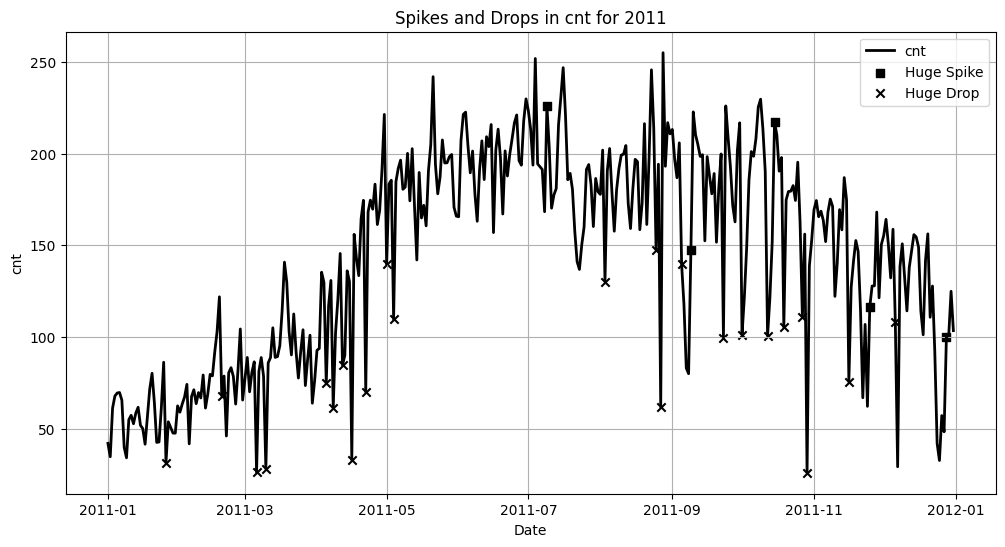

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_2011['dteday'], df_2011['cnt'], color='black', linewidth=2, label='cnt')
plt.scatter(df_2011['dteday'][df_2011['spike_flag'] == 1],
            df_2011['cnt'][df_2011['spike_flag'] == 1],
            marker='s', color='black', label='Huge Spike')
plt.scatter(df_2011['dteday'][df_2011['drop_flag'] == 1],
            df_2011['cnt'][df_2011['drop_flag'] == 1],
            marker='x', label='Huge Drop', color='black')
plt.title('Spikes and Drops in cnt for 2011')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Filter rows where spike_flag or drop_flag is 1
spikes_and_drops = df_2011[(df_2011['spike_flag'] == 1) | (df_2011['drop_flag'] == 1)]

# Print the filtered data
print("Days with Huge Spikes or Drops:")
print(spikes_and_drops)


Days with Huge Spikes or Drops:
        dteday         cnt    cnt_diff  spike_flag  drop_flag
25  2011-01-26   31.625000  -54.679348           0          1
49  2011-02-19   68.125000  -53.833333           0          1
64  2011-03-06   26.304348  -60.237319           0          1
68  2011-03-10   28.318182  -50.473485           0          1
94  2011-04-05   74.791667  -55.000000           0          1
97  2011-04-08   61.291667  -69.583333           0          1
101 2011-04-12   84.750000  -60.815217           0          1
105 2011-04-16   33.125000  -97.125000           0          1
111 2011-04-22   70.125000 -104.416667           0          1
120 2011-05-01  139.625000  -81.708333           0          1
123 2011-05-04  109.708333  -75.750000           0          1
189 2011-07-09  225.913043   57.579710           1          0
214 2011-08-03  130.272727  -71.602273           0          1
236 2011-08-25  147.583333  -66.166667           0          1
238 2011-08-27   61.944444 -132.263889

In [ ]:
#Apply to 2012 data
spike_dates_2011 = df_2011.loc[df_2011['spike_flag'] == 1, 'dteday']
drop_dates_2011 = df_2011.loc[df_2011['drop_flag'] == 1, 'dteday']

spike_dates_2012 = spike_dates_2011.apply(lambda x: x.replace(year=2012))
drop_dates_2012 = drop_dates_2011.apply(lambda x: x.replace(year=2012))

# Combine 2011 and 2012 spike and drop dates
all_spike_dates = pd.concat([spike_dates_2011, spike_dates_2012])
all_drop_dates = pd.concat([drop_dates_2011, drop_dates_2012])

data['spike_flag'] = data['dteday'].isin(all_spike_dates).astype(int)
data['drop_flag'] = data['dteday'].isin(all_drop_dates).astype(int)

# Display the updated dataframe
data['drop_flag'].value_counts()
data['spike_flag'].value_counts()

test['spike_flag'] = test['dteday'].isin(all_spike_dates).astype(int)
test['drop_flag'] = test['dteday'].isin(all_drop_dates).astype(int)

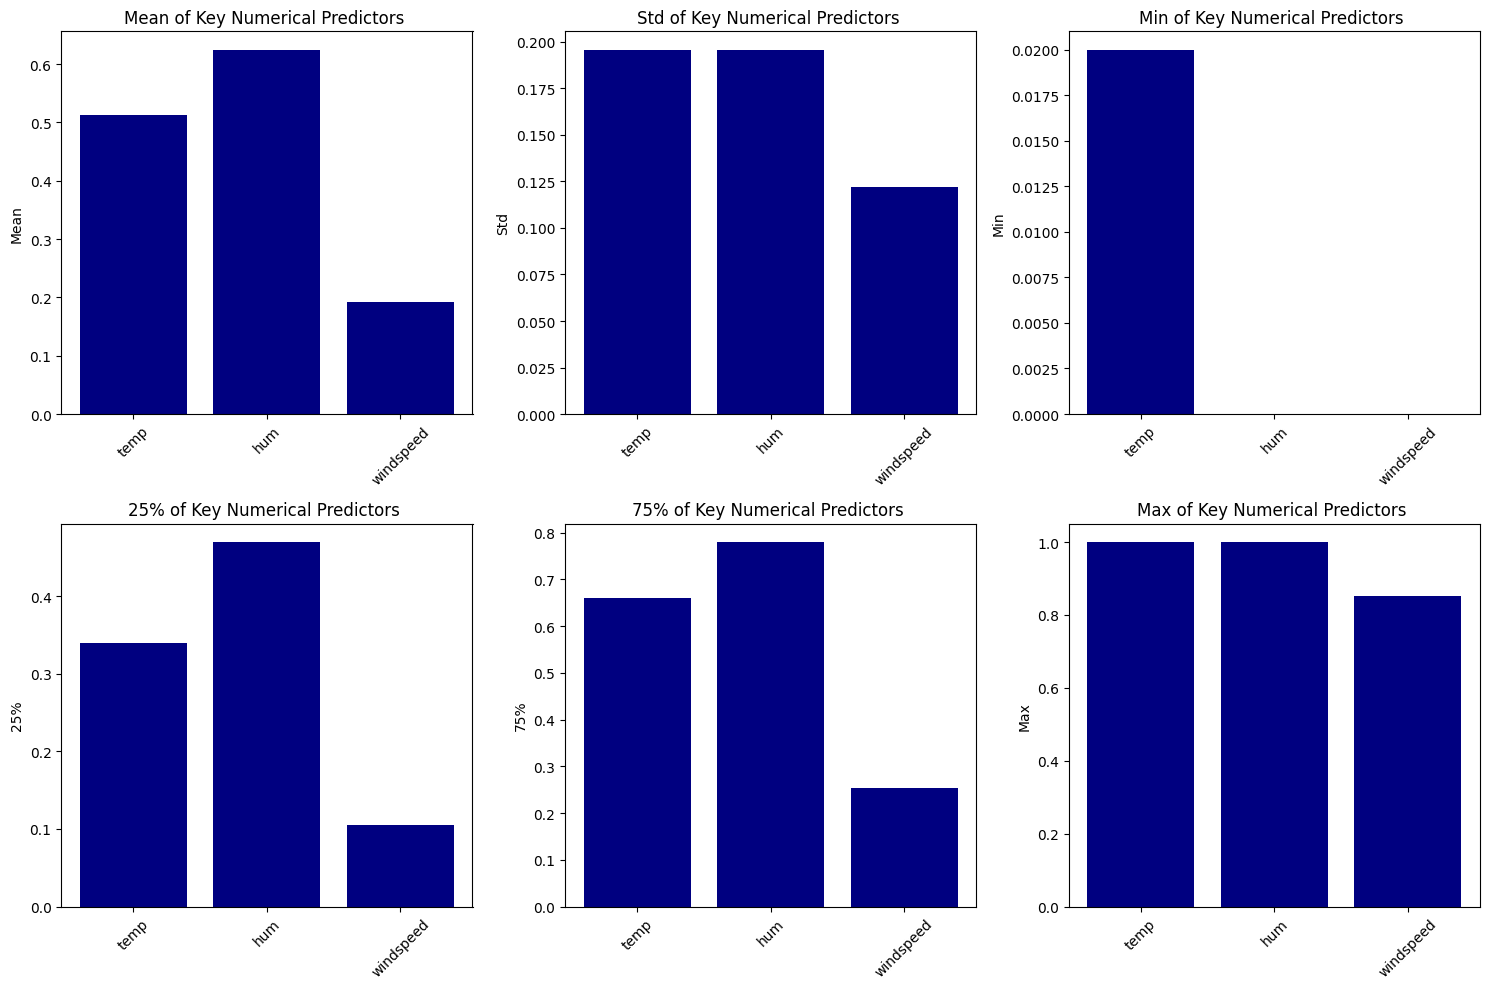

In [ ]:
import math
#keeping numerical columns and compute descriptive statistics
desc_stats = data[['temp', 'hum', 'windspeed']].describe()
#dropping %50 and count as we dont really care (50 is the median so would be plotted twice, count is not interesting at this stage)
desc_stats = desc_stats.drop(['50%', 'count'])
#defining the rows and cols for the matrix plotting grid
num_stats = len(desc_stats.index)
cols = 3
rows = math.ceil(num_stats / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()
#looping through each stats and create a bar plot
for i, stat in enumerate(desc_stats.index):
    ax = axes[i]
    ax.bar(desc_stats.columns, desc_stats.loc[stat], color='navy')
    ax.set_title(f"{stat.capitalize()} of Key Numerical Predictors ")
    ax.set_ylabel(stat.capitalize())
    #ax.set_xlabel("Columns")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


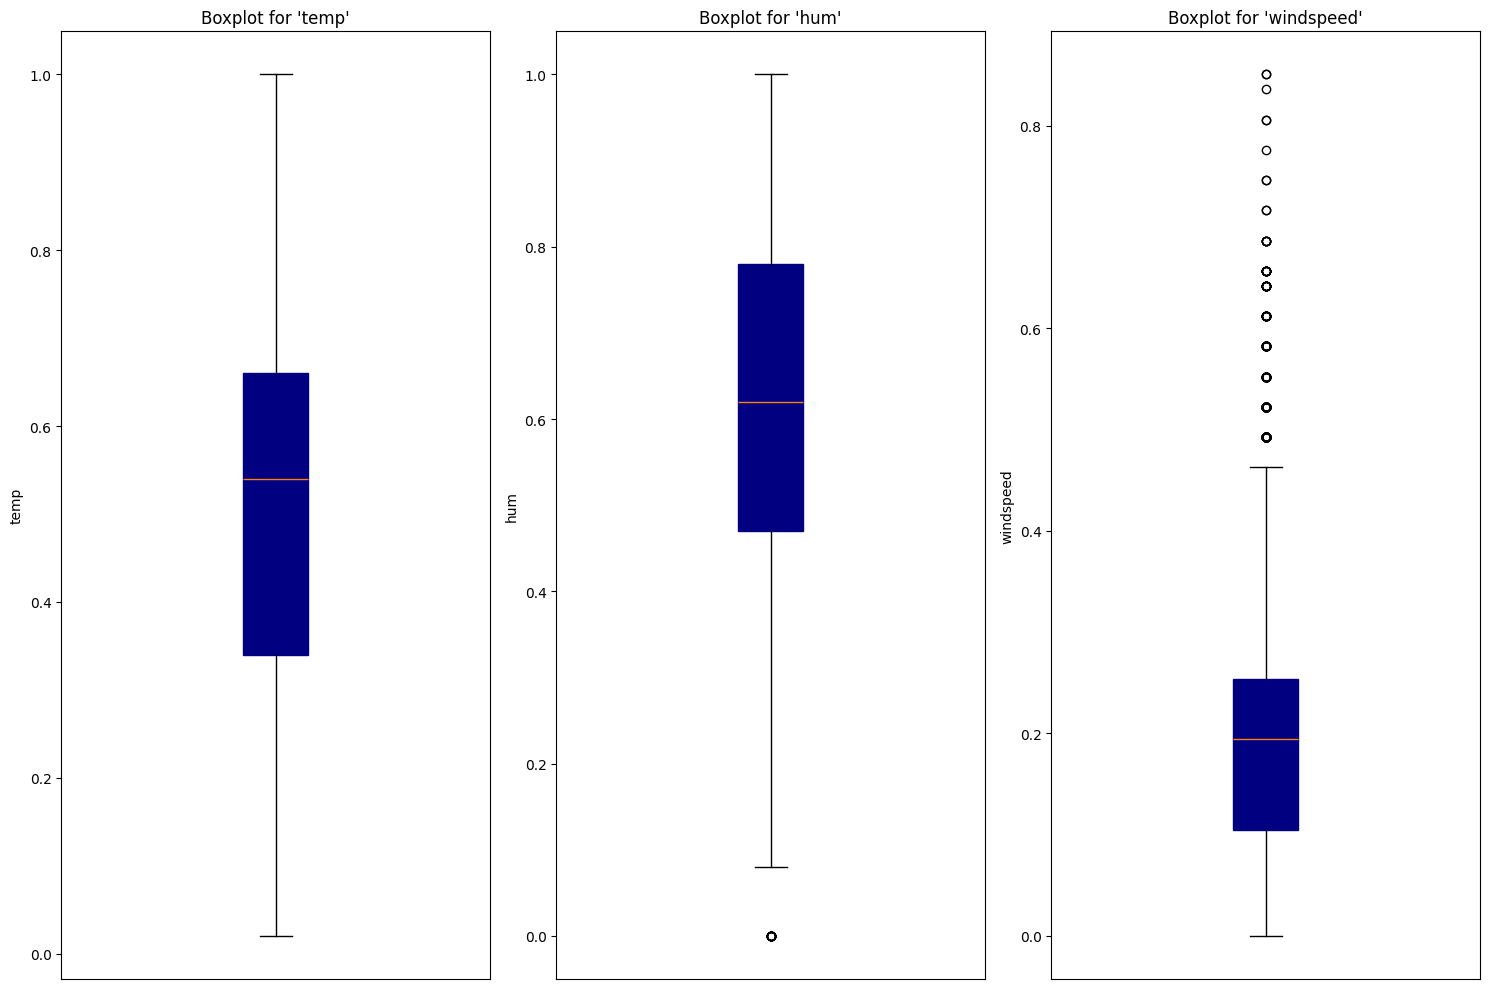

In [ ]:
key_columns = data[['temp', 'hum', 'windspeed']]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5 * rows))
axes = axes.flatten()
for i, column in enumerate(key_columns.columns):
    ax = axes[i]
    ax.boxplot(key_columns[column].dropna(), vert=True, patch_artist=True,
               boxprops=dict(facecolor='navy', color='navy'))
    ax.set_title(f"Boxplot for '{column}'")
    ax.set_ylabel(column)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

In [ ]:
z_scores = np.abs((data['cnt'] -data['cnt'].mean()) / data['cnt'].std())
outliers = np.where(z_scores > 3)[0]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 219


## Time series analysis

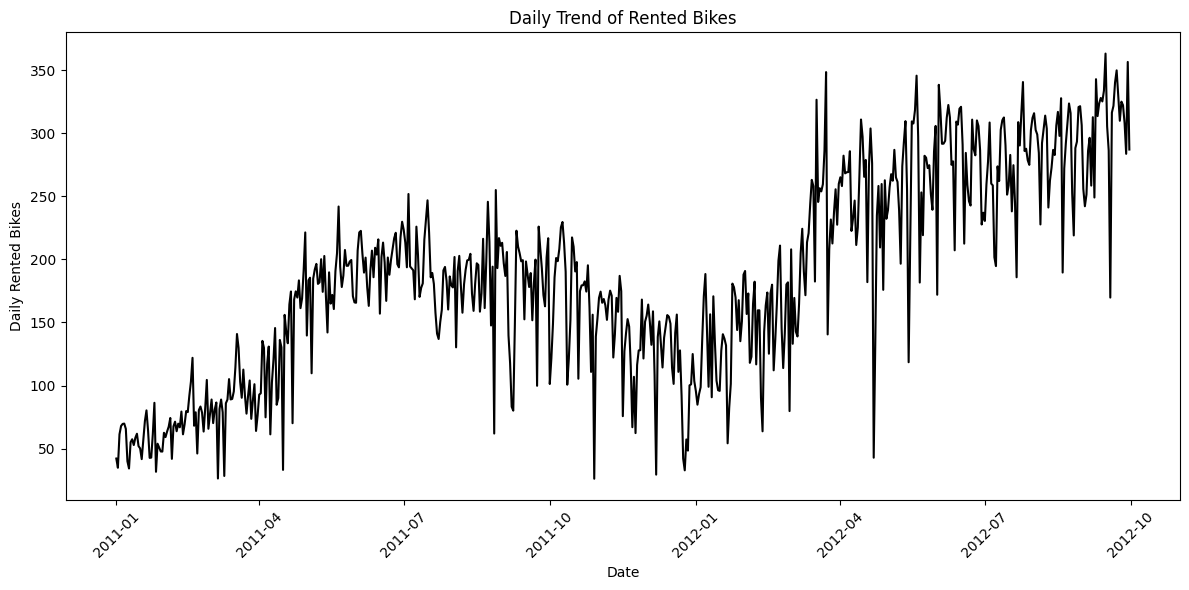

In [ ]:
# Daily trends over the entire time span
daily_trend = data.groupby('dteday')['cnt'].mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_trend.index, daily_trend.values, color='black')  # Line in black without markers
plt.title("Daily Trend of Rented Bikes")
plt.xlabel("Date")
plt.ylabel("Daily Rented Bikes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Trend by season

In [ ]:
#trend by season
season_data = data[data['yr'] == 2011] #just looking at 2011 where we have full hourly data
season_trend = season_data.groupby('season')['cnt'].sum().reset_index()
season_trend

season     cnt
0    Fall  325085
1  Spring  346828
2  Summer  418678
3  Winter  149984

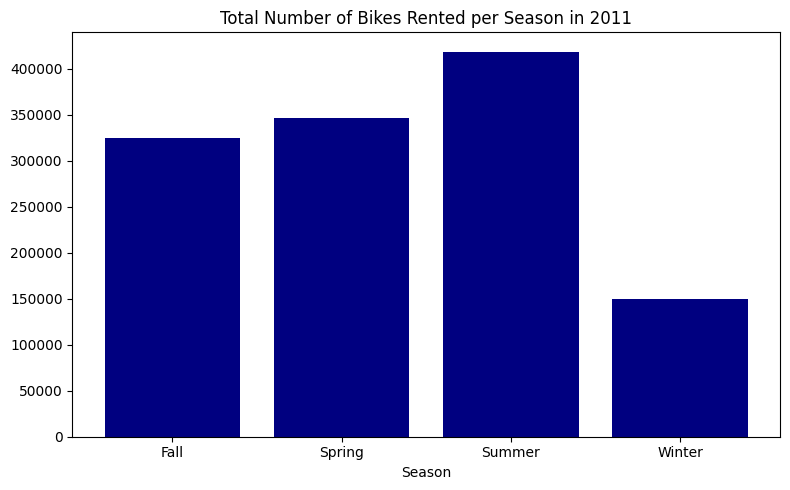

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(season_trend['season'], season_trend['cnt'], color='navy')
plt.title("Total Number of Bikes Rented per Season in 2011")
plt.xlabel("Season")
plt.xticks([0, 1, 2, 3], ['Fall', 'Spring', 'Summer', 'Winter'])
plt.tight_layout()
plt.show()

### Trend by days of week

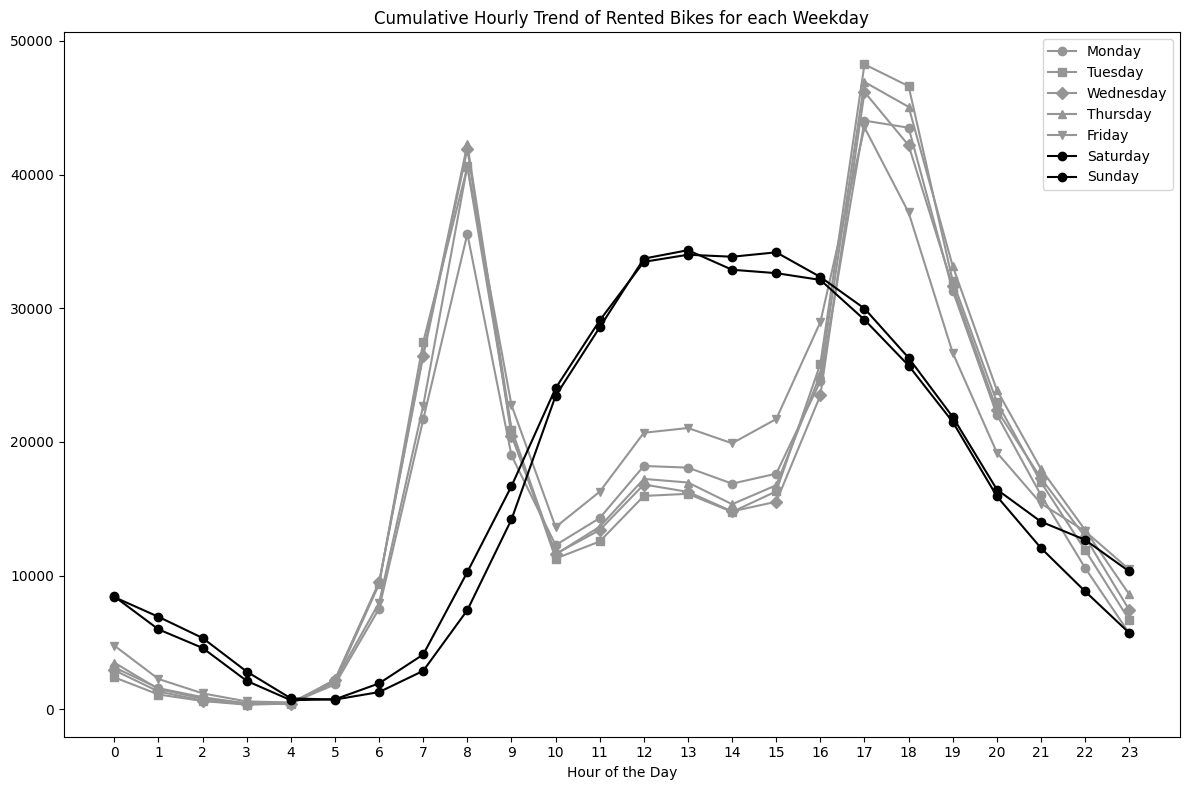

In [ ]:
#hourly trend per different days
#grouping by weekday and hour, the sum to have a cumulative curve
hourly_trend = data.groupby(['weekday', 'hr'])['cnt'].sum().reset_index()

navy_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
firebrick_days = ['Saturday', 'Sunday']
markers = ['o', 's', 'D', '^', 'v']  # different markers for different weekdays

plt.figure(figsize=(12, 8))
for idx, day in enumerate(navy_days): #looping in the weekdays
    daily_data = hourly_trend[hourly_trend['weekday'] == day]
    plt.plot(daily_data['hr'], daily_data['cnt'], label=day,
             marker=markers[idx % len(markers)], color=plt.cm.Greys(0.5))
for day in firebrick_days: #same for weekends
    daily_data = hourly_trend[hourly_trend['weekday'] == day]
    plt.plot(daily_data['hr'], daily_data['cnt'], label=day,
             marker='o', color='black')

plt.title("Cumulative Hourly Trend of Rented Bikes for each Weekday")
plt.xlabel("Hour of the Day")
plt.legend()
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### Weather trends

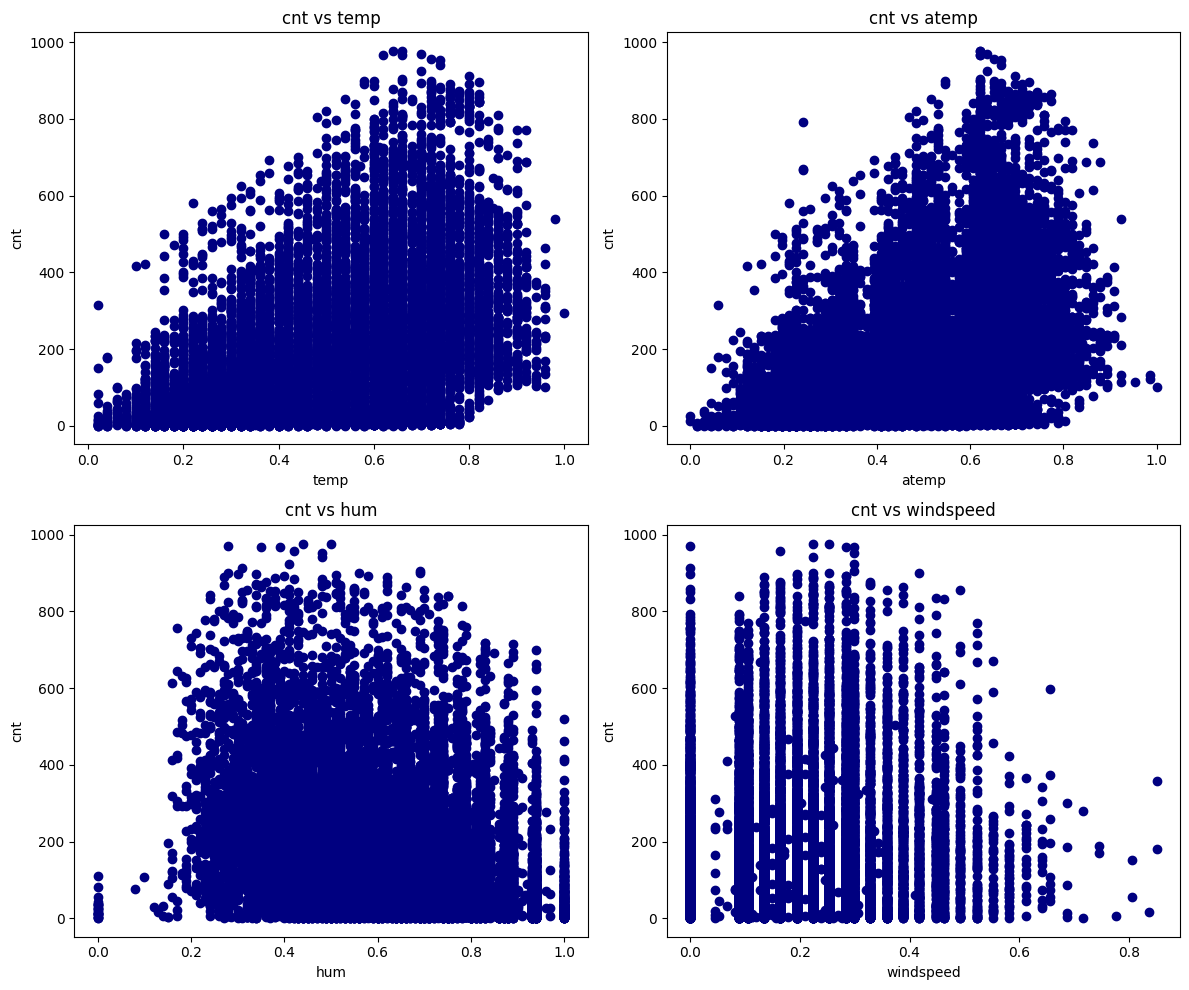

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
navy = 'navy'
axes[0, 0].scatter(data['temp'], data['cnt'], color=navy)
axes[0, 0].set_title('cnt vs temp')
axes[0, 0].set_xlabel('temp')
axes[0, 0].set_ylabel('cnt')
axes[0, 1].scatter(data['atemp'], data['cnt'], color=navy)
axes[0, 1].set_title('cnt vs atemp')
axes[0, 1].set_xlabel('atemp')
axes[0, 1].set_ylabel('cnt')
axes[1, 0].scatter(data['hum'], data['cnt'], color=navy)
axes[1, 0].set_title('cnt vs hum')
axes[1, 0].set_xlabel('hum')
axes[1, 0].set_ylabel('cnt')
axes[1, 1].scatter(data['windspeed'], data['cnt'], color=navy)
axes[1, 1].set_title('cnt vs windspeed')
axes[1, 1].set_xlabel('windspeed')
axes[1, 1].set_ylabel('cnt')
plt.tight_layout()
plt.show()


## Feature Engineering

### Starting Feature Engineering

In [ ]:
test.head()

Id     dteday season    yr     mnth  hr holiday weekday workingday  \
0  15212 2012-10-01   Fall  2012  October   0      No  Monday        Yes   
1  15213 2012-10-01   Fall  2012  October   1      No  Monday        Yes   
2  15214 2012-10-01   Fall  2012  October   2      No  Monday        Yes   
3  15215 2012-10-01   Fall  2012  October   3      No  Monday        Yes   
4  15216 2012-10-01   Fall  2012  October   4      No  Monday        Yes   

                                        weathersit  temp   atemp   hum  \
0  Clear, Few clouds, Partly cloudy, Partly cloudy  0.46  0.4545  0.72   
1  Clear, Few clouds, Partly cloudy, Partly cloudy  0.44  0.4394  0.77   
2  Clear, Few clouds, Partly cloudy, Partly cloudy  0.46  0.4545  0.72   
3  Clear, Few clouds, Partly cloudy, Partly cloudy  0.44  0.4394  0.77   
4  Clear, Few clouds, Partly cloudy, Partly cloudy  0.42  0.4242  0.82   

   windspeed    year  month  day  spike_flag  drop_flag  
0     0.1045  2012.0   10.0  1.0           0          1  
1     0.0896  2012.0   10.0  1.0           0          1  
2     0.0000  2012.0   10.0  1.0           0          1  
3     0.0000  2012.0   10.0  1.0           0          1  
4     0.1045  2012.0   10.0  1.0           0          1

In [ ]:
#Mapping of categorical variables
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
weekday_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4,
    'Saturday': 5, 'Sunday': 6}
holiday_mapping= {'Yes': 1, 'No': 0}
workingday_mapping= {'Yes': 1, 'No': 0}
weathersit_mapping= {'Clear, Few clouds, Partly cloudy, Partly cloudy': 1,
                     'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist': 2,
                     'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds': 3,
                     'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog': 4}

#interactions and complex features in both datasets
def mapping(df):
  df['season_num'] = df['season'].map(season_mapping)
  df['weekday_num'] = df['weekday'].map(weekday_mapping)
  df['holiday_num'] = df['holiday'].map(holiday_mapping)
  df['workingday_num'] = df['workingday'].map(workingday_mapping)
  df['weathersit_num'] = df['weathersit'].map(weathersit_mapping)
  df['temp_hum'] = df['temp'] * df['hum'] #interaction of temperature and humidity
  df['temp_windspeed'] = df['temp'] * df['windspeed'] #interaction of temperature and windspeed
  df['windspeed'] = df['windspeed'] * df['windspeed'] #windspeed squared
  df['time_of_day'] = pd.cut(df['hr'], bins=[0, 6, 9, 15, 19, 23], right=True, include_lowest=True) #peak hours
  df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True)
  df['hum_windspeed'] = df['hum'] * df['windspeed'] #interaction of humidity and windspeed
  df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24) #sin of hour
  df['hr_workingday'] = df['hr'] * df['workingday_num'] #interaction of hour and working day dummy
  df['hour_weekday_interaction'] = df['hr'] * df['weekday_num'] #interaction of hour and weekday dummy
  df['hr_fourier'] = np.sin(2 * np.pi * df['hr'] / 24)  #fourier transformation to hour
  df['day_hr_sin_interaction'] = df['day'] * df['hr_sin'] #interaction of hour and cos of hour
  df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) #sin of month
  df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12) #cos of month
  df['rain'] = (df['weathersit_num'] >= 3).astype(int) #rain dummy
  df['rain_temp_interaction'] = df['rain'] * df['temp'] #rnteraction of rain and temperature

  return df

test = mapping(test)
data = mapping(data)

In [ ]:
# Change column names
data = data.drop(columns=['season', 'weekday'])
test = test.drop(columns=['season', 'weekday'])

data = data.rename(columns={'season_num': 'season', 'weekday_num': 'weekday'})
test = test.rename(columns={'season_num': 'season', 'weekday_num': 'weekday'})


In [ ]:
# Define the peak hours for working and non-working days
working_day_peak_hours = [8.0, 17.0, 18.0, 19.0]
non_working_day_peak_hours = [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]

# Create a new column 'hour_pick' based on the hour and workingday_num
data['hour_pick'] = data.apply(
    lambda row: 1 if (row['hr'] in working_day_peak_hours and row['workingday_num'] == 1) or
                (row['hr'] in non_working_day_peak_hours and row['workingday_num'] == 0) else 0, axis=1
)

print(data[['hr', 'workingday_num', 'hour_pick']].head())
test['hour_pick'] = test.apply(
    lambda row: 1 if (row['hr'] in working_day_peak_hours and row['workingday_num'] == 1) or
                (row['hr'] in non_working_day_peak_hours and row['workingday_num'] == 0) else 0, axis=1
)

    hr  workingday_num  hour_pick
1  1.0               0          0
2  2.0               0          0
3  3.0               0          0
4  4.0               0          0
5  5.0               0          0


In [ ]:
# Drop categorical columns that has been transform to numerical
data = data.drop(['year','mnth','workingday','holiday','weathersit'],axis=1)
test = test.drop(['year','mnth','workingday','holiday','weathersit'],axis=1)


### Outliers

#### Log or Cube Root Transofmration of the Skewed Distributions

To apply z-score for elimination of outliers we first need to check at the skewness of the predictors!

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15186 entries, 1 to 15210
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        15186 non-null  int64         
 1   dteday                    15186 non-null  datetime64[ns]
 2   yr                        15186 non-null  float64       
 3   hr                        15186 non-null  float64       
 4   temp                      15186 non-null  float64       
 5   atemp                     15186 non-null  float64       
 6   hum                       15186 non-null  float64       
 7   windspeed                 15186 non-null  float64       
 8   cnt                       15186 non-null  int64         
 9   month                     15186 non-null  float64       
 10  day                       15186 non-null  float64       
 11  spike_flag                15186 non-null  int64         
 12  drop_flag              

A lot of featues are just numerical transformed booleans, so we only apply a log transformation to floating type predictors as the skewness for var 0 or 1 wil reamin even if log trans is applyed. Moreover log(0) is not mathematically feasible...

In [ ]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
skewness = numeric_cols.skew()

# Display skewness
print("Skewness of numeric columns:")
print(skewness)

Skewness of numeric columns:
Id                         -0.000180
yr                          0.276028
hr                         -0.010396
temp                       -0.151247
atemp                      -0.228763
hum                        -0.113004
windspeed                   2.673786
cnt                         1.298696
month                       0.161318
day                         0.010608
spike_flag                  9.408000
drop_flag                   3.696422
season                      0.134419
weekday                    -0.008634
holiday_num                 5.876267
workingday_num             -0.795487
weathersit_num              1.286829
temp_hum                    0.048724
temp_windspeed              0.996206
hum_windspeed               3.130386
hr_sin                      0.010526
hr_workingday               0.479983
hour_weekday_interaction    1.004432
hr_fourier                  0.010526
day_hr_sin_interaction      0.005094
month_sin                  -0.155717
month_cos

trandfroaming all flaoting type with skewness <-0.5 and > 0.5

In [ ]:
columns_to_transform = ['windspeed','temp_windspeed','hum_windspeed','hour_weekday_interaction']
#include only the specified columns
selected_columns = data[columns_to_transform]

skewness = selected_columns.skew()
print("Skewness of selected columns:")
print(skewness)


Skewness of selected columns:
windspeed                   2.673786
temp_windspeed              0.996206
hum_windspeed               3.130386
hour_weekday_interaction    1.004432
dtype: float64


In [ ]:
data_log = selected_columns.apply(np.log1p)
data_log.skew()

windspeed                   2.230059
temp_windspeed              0.771607
hum_windspeed               2.687818
hour_weekday_interaction   -0.745760
dtype: float64

Here we still have more than two vars skewed

In [ ]:
data_cbrt = selected_columns.apply(np.cbrt)
data_cbrt.skew()

windspeed                  -0.325244
temp_windspeed             -1.170551
hum_windspeed              -0.390662
hour_weekday_interaction   -0.536062
dtype: float64

Here only stemp_wind_sped is skewd hence we apply log to this and cube rott to the otehrs

In [ ]:
columns_to_cbrt = ['windspeed','hum_windspeed','hour_weekday_interaction']
columns_to_log1p = ['temp_windspeed']

In [ ]:
#copy the original dataset to store transformed data
data_transf = data.copy()
#cube root transformation
data_transf[columns_to_cbrt] = data_transf[columns_to_cbrt].apply(np.cbrt)
#log1p transformation
data_transf[columns_to_log1p] = data_transf[columns_to_log1p].apply(np.log1p)
#check transformations by checking skewness
print("Skewness after transformations:")
print(data_transf[columns_to_cbrt + columns_to_log1p].skew())

#aplso apply to test set for future error resutls
test_transf= test.copy()
test_transf[columns_to_cbrt] = test_transf[columns_to_cbrt].apply(np.cbrt)
test_transf[columns_to_log1p] = test_transf[columns_to_log1p].apply(np.log1p)
# backward fill empty cells due to lagging features
test_transf = test_transf.bfill()
print(test_transf.isna().sum().sum())



Skewness after transformations:
windspeed                  -0.325244
hum_windspeed              -0.390662
hour_weekday_interaction   -0.536062
temp_windspeed              0.771607
dtype: float64
0


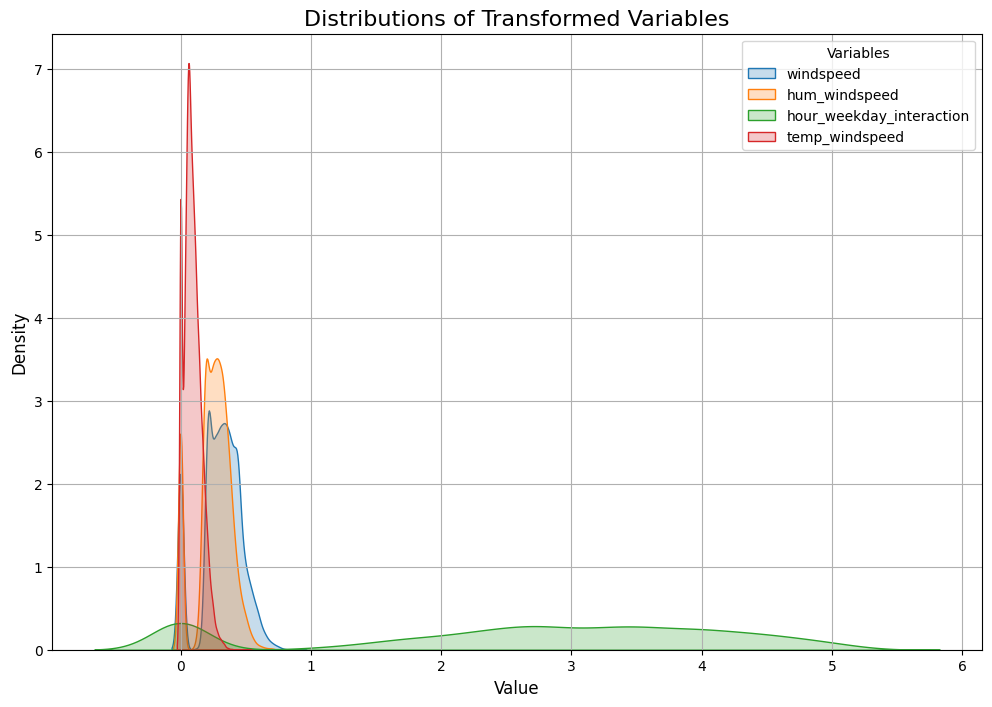

In [ ]:
columns_to_plot = columns_to_cbrt + columns_to_log1p
plt.figure(figsize=(12, 8))

#distributions of each transformed variable
for column in columns_to_plot:
    sns.kdeplot(data_transf[column], label=column, fill=True)

# Customize the plot
plt.title("Distributions of Transformed Variables", fontsize=16)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Variables", fontsize=10)
plt.grid(True)
plt.show()


#### Outliers detection via Z-Score

In [ ]:
from scipy.stats import zscore

#Z-scores for the transformed dataset (considering only the transformed columns)
z_scores = data_transf[columns_to_plot].apply(zscore)
#threshold for outlier detection
threshold = 2

# Identify rows with outliers and elimante them
outliers = (z_scores > threshold) | (z_scores < -threshold)
outlier_indices = data_transf.index[outliers.any(axis=1)]
data_no_outliers = data_transf.drop(index=outlier_indices)
#check the new dataset's skewness after outlier removal
print("Skewness after outlier removal:")
print(data_no_outliers[columns_to_plot].skew())
X_test_transf = test_transf.drop(['Id', 'dteday'], axis = 1)


Skewness after outlier removal:
windspeed                   0.399583
hum_windspeed               0.399134
hour_weekday_interaction   -0.542851
temp_windspeed              0.510768
dtype: float64


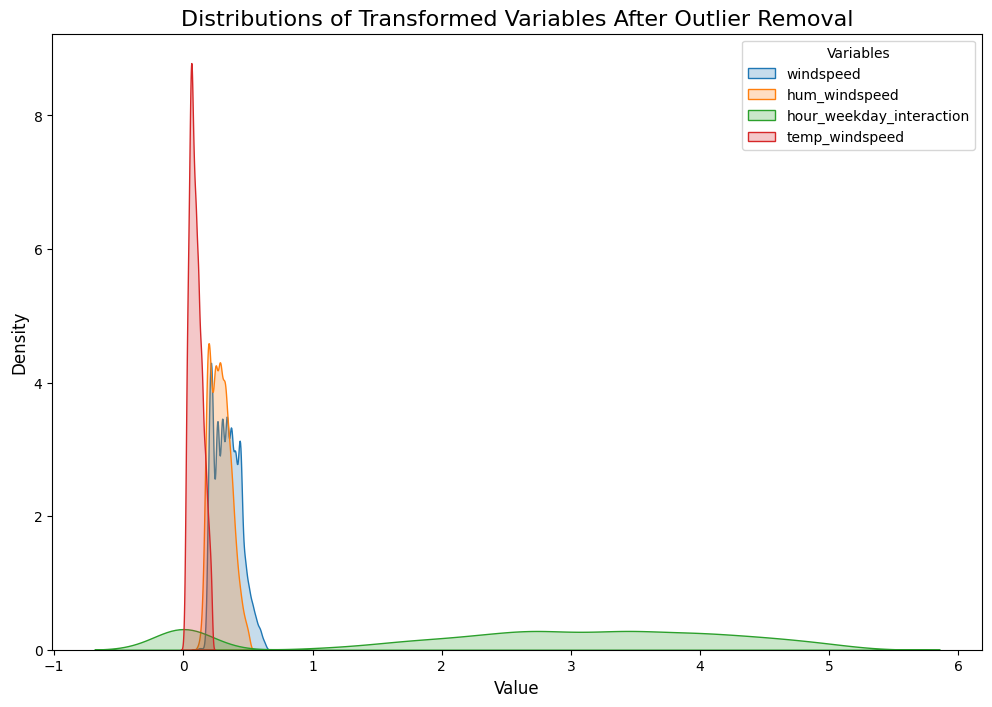

In [ ]:
#the distributions of the variables in the new dataset
plt.figure(figsize=(12, 8))
for column in columns_to_plot:
    sns.kdeplot(data_no_outliers[column], label=column, fill=True)

# Customize the plot
plt.title("Distributions of Transformed Variables After Outlier Removal", fontsize=16)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Variables", fontsize=10)
plt.grid(False)
plt.show()

In [ ]:
num_outliers = outlier_indices.shape[0]
print(f"Number of eliminated observations due to Z-score outlier removal: {num_outliers}")


Number of eliminated observations due to Z-score outlier removal: 2662


These are still far from unimodal normal distributions, but nothing we can do to change their nature :(

### Correlations

In [ ]:
# time
data_time = data[['cnt','season', 'yr', 'hr', 'weekday', 'month', 'day', 'holiday_num', 'workingday_num',
       'hr_sin', 'hr_workingday', 'hour_weekday_interaction',
       'hr_fourier', 'day_hr_sin_interaction', 'month_sin', 'month_cos', 'time_of_day_(6.0, 9.0]',
       'time_of_day_(9.0, 15.0]', 'time_of_day_(15.0, 19.0]',
       'time_of_day_(19.0, 23.0]']]

data_not_time = data[['cnt', 'temp', 'atemp', 'hum', 'windspeed',
       'weathersit_num', 'temp_hum', 'temp_windspeed', 'hum_windspeed',
       'rain', 'rain_temp_interaction', 'rain_temp_interaction']]


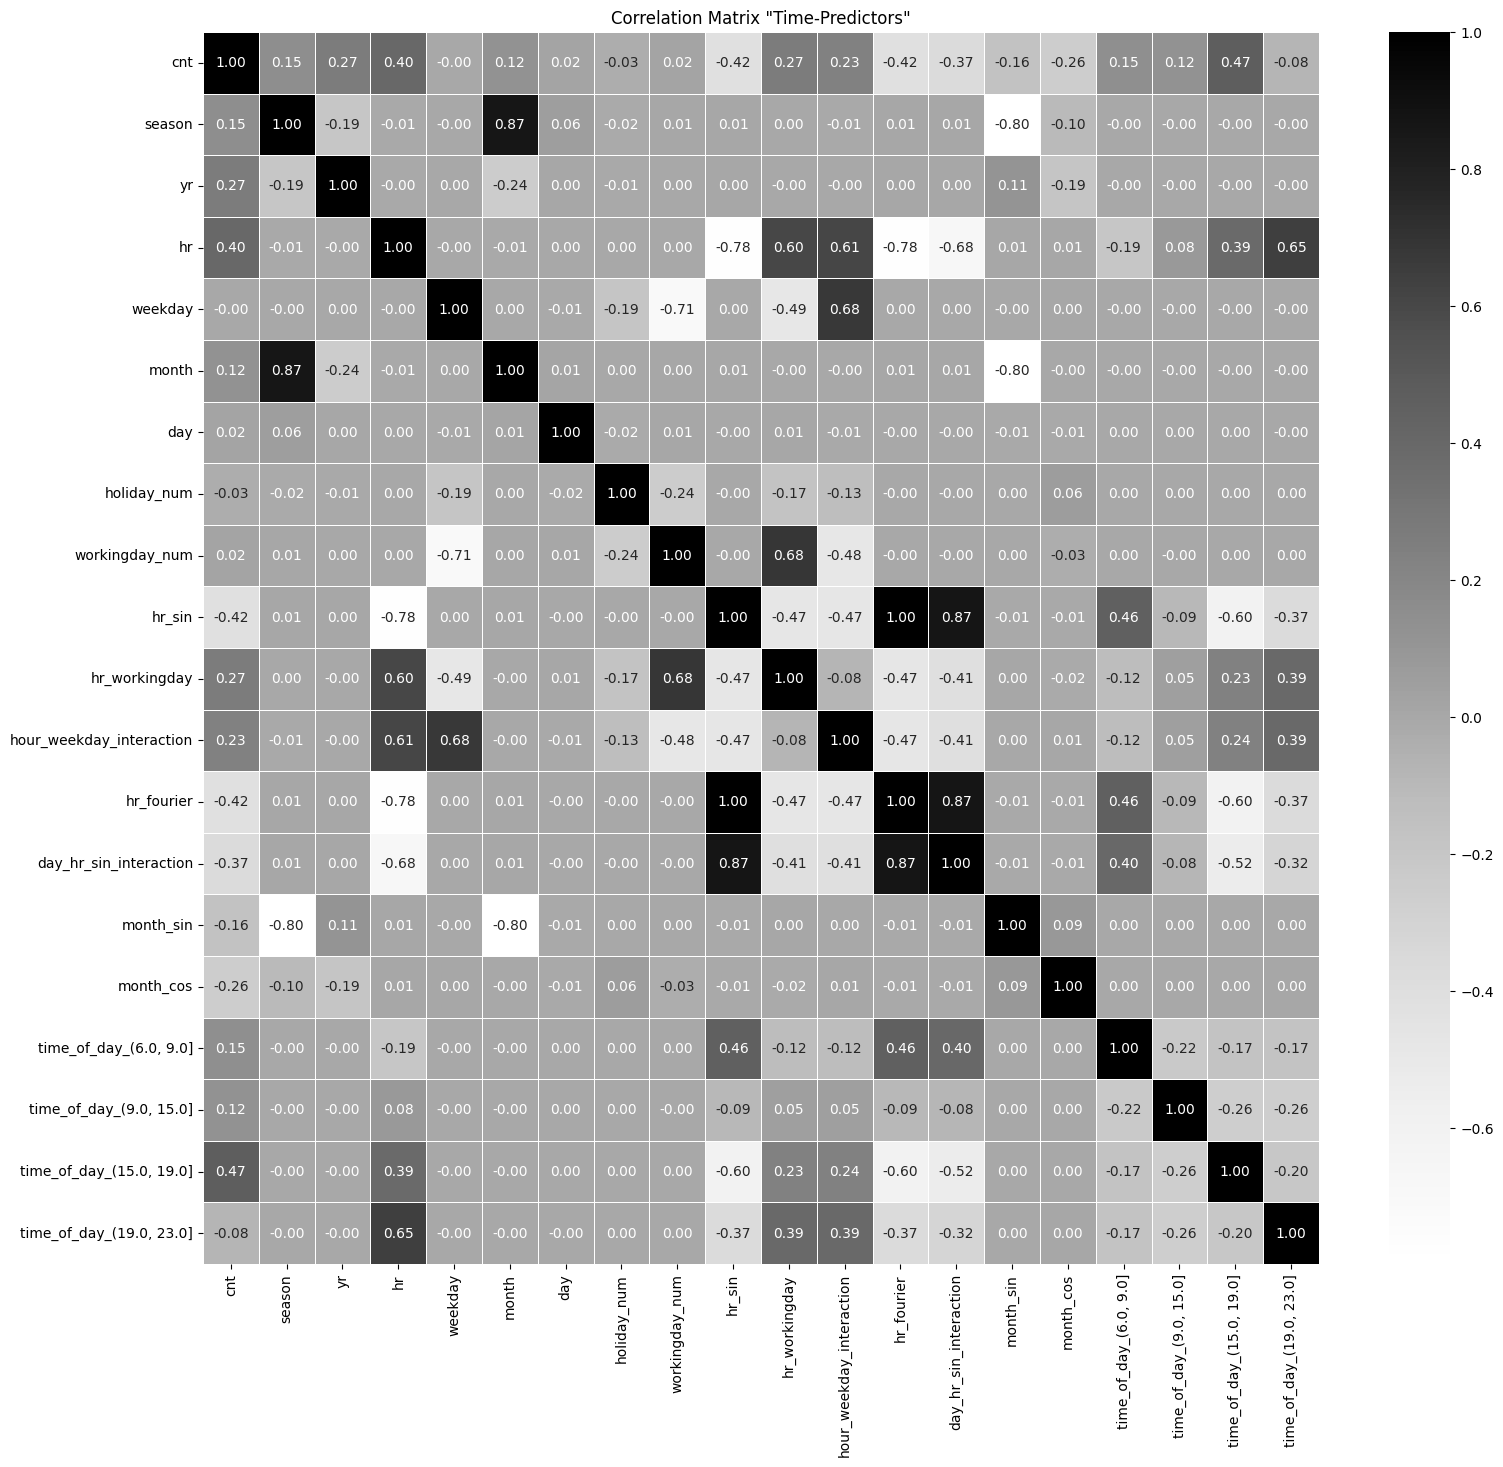

In [ ]:
#correlation matrix heatmap
correlation_matrix = data_time.corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix "Time-Predictors"')
plt.show()


Non-informative predictors:
- weekday -> corr =~ 0
- time_of_day[19.0, 23.0] -> corr == -0.08
- working_day_num -> corr == 0.02
- holiday_num -> corr = 0.02
- day -> corr == -0.02

Redundant predictors (highly correlated among themselves):

*   hr_fourier and hr_sin
*   hr_sin and day_hr_sin_interactions
*   season and month


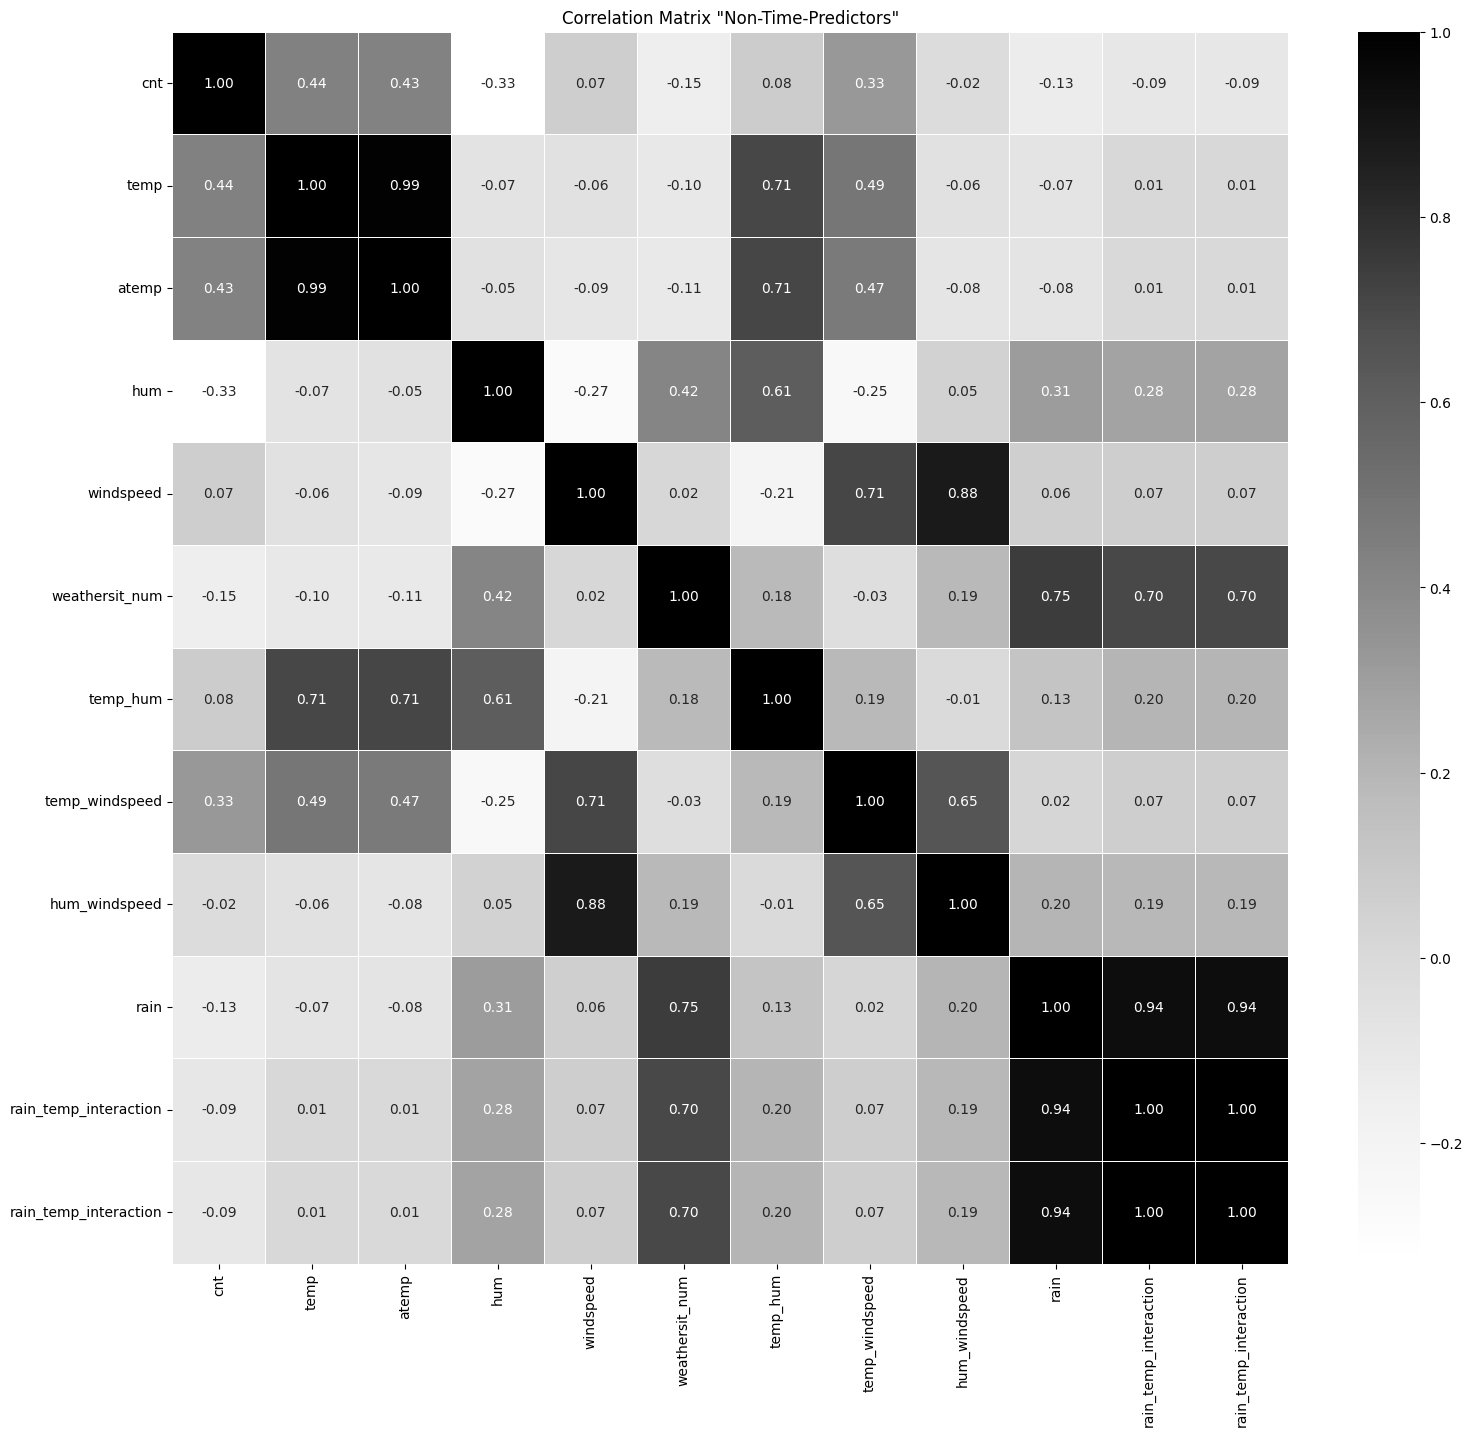

In [ ]:
correlation_matrix = data_not_time.corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix "Non-Time-Predictors"')
plt.show()


Non-informative predictors:
- hum_windspeed -> corr == -0.02
- temp_hum -> corr == 0.08
- rain_temp_interaction -> corr == 0.09

Redundant predictors (highly correlated among themselves):
- rain and rain_temp_interaction
- hum_windspeed and windspeed
- temp and atemp

In [ ]:
# Create a restricted data by droping uninformative predictors and variables highly correlate among themselves
data_restricted = data.drop(['rain_temp_interaction','hum_windspeed','atemp','weekday','time_of_day_(19.0, 23.0]',
                             'workingday_num', 'holiday_num', 'day', 'hr_sin', 'month'],axis=1)
test_restricted = test.drop(['rain_temp_interaction','hum_windspeed','atemp','weekday','time_of_day_(19.0, 23.0]',
                             'workingday_num', 'holiday_num', 'day', 'hr_sin', 'month'],axis=1)

###Feature Engineering with Baseline Model

#### Using Starting (first step) Features

In [ ]:
# without rollings stats and lagging features
X = data.drop(columns=['Id', 'cnt','dteday'])
y = data['cnt']
X = pd.get_dummies(X, drop_first=True)
columns_1 =X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_baseline_1 = RandomForestRegressor(random_state=42)
rf_model_baseline_1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

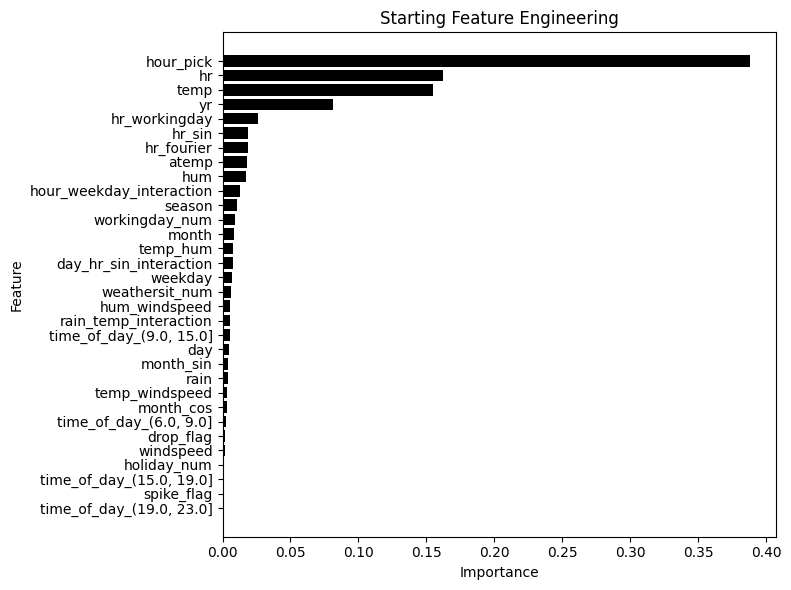

In [ ]:
feature_importances_1 = pd.DataFrame({'Feature': columns_1, 'Importance': rf_model_baseline_1.feature_importances_})
feature_importances_1 = feature_importances_1.sort_values(by='Importance', ascending=False)

#First plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importances_1['Feature'], feature_importances_1['Importance'], color='black')
plt.title("Starting Feature Engineering")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Adding Lagging Features

In [ ]:
#lagging hour
data['hour_lag_1'] = data['hr'].shift(1)
test['hour_lag_1'] = test['hr'].shift(1)
#lagging weekday
data['weekday_lag'] = data['weekday'].shift(7)
test['weekday_lag'] = test['weekday'].shift(7)


In [ ]:
# with lagging features
X = data.drop(columns=['Id', 'cnt','dteday'])
y = data['cnt']
X = pd.get_dummies(X, drop_first=True)
columns_2 = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_baseline_2 = RandomForestRegressor(random_state=42)
rf_model_baseline_2.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

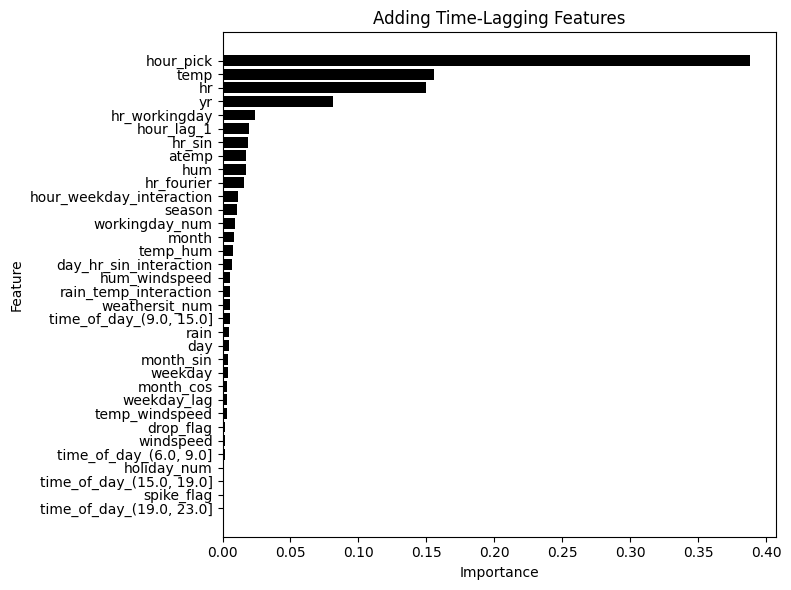

In [ ]:
feature_importances_2 = pd.DataFrame({'Feature': columns_2, 'Importance': rf_model_baseline_2.feature_importances_})
feature_importances_2 = feature_importances_2.sort_values(by='Importance', ascending=False)

#2nd plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importances_2['Feature'], feature_importances_2['Importance'], color='black')
plt.title("Adding Time-Lagging Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Adding Weather Rolling Statistics

In [ ]:
#rolling 7-day average and std for temperature or humidity
data['rolling_temp_mean'] = data['temp'].rolling(window=7).mean()
test['rolling_temp_mean'] = test['temp'].rolling(window=7).mean()
data['rolling_humidity_mean'] = data['hum'].rolling(window=7).mean()
test['rolling_humidity_mean'] = test['hum'].rolling(window=7).mean()
data['rolling_temp_std'] = data['temp'].rolling(window=7).std()
test['rolling_temp_std'] = test['temp'].rolling(window=7).std()
data['rolling_humidity_std'] = data['hum'].rolling(window=7).std()
test['rolling_humidity_std'] = test['hum'].rolling(window=7).std()


In [ ]:
# with rollings stats and lagging features
X = data.drop(columns=['Id', 'cnt','dteday'])
y = data['cnt']
X = pd.get_dummies(X, drop_first=True)
columns_3 =X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_baseline_3= RandomForestRegressor(random_state=42)
rf_model_baseline_3.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
feature_importances_3 = pd.DataFrame({'Feature': columns_3, 'Importance': rf_model_baseline_3.feature_importances_})
feature_importances_3 = feature_importances_3.sort_values(by='Importance', ascending=False)

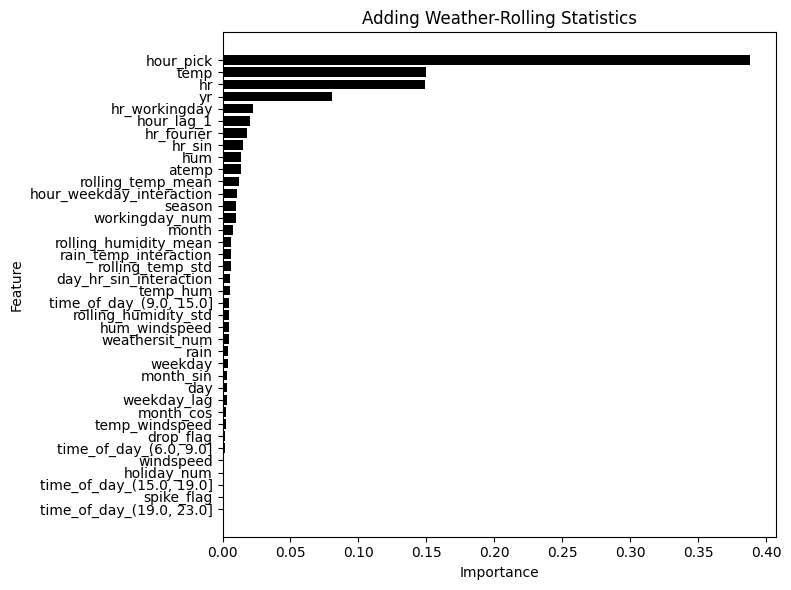

In [ ]:
#third plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importances_3['Feature'], feature_importances_3['Importance'], color='black')
plt.title("Adding Weather-Rolling Statistics")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


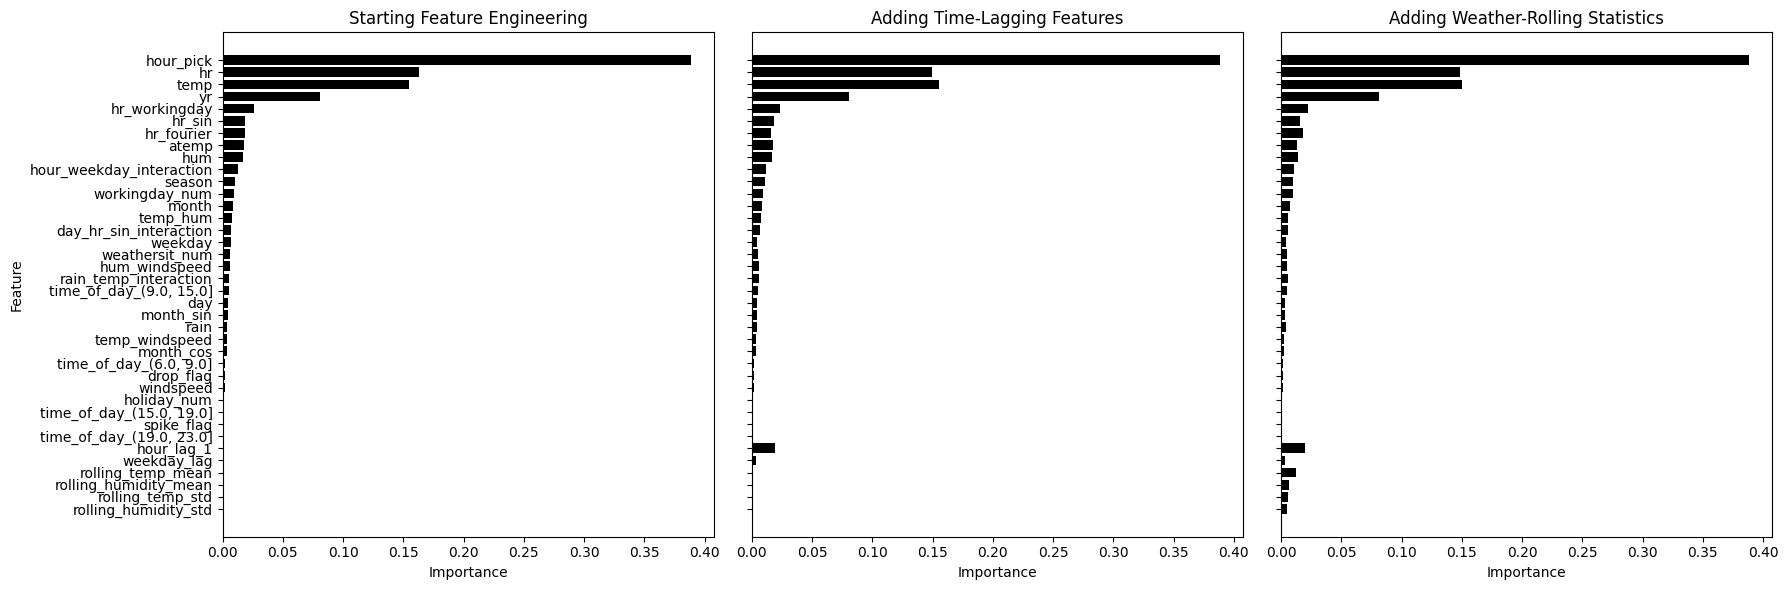

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#feature importance with rf_model_baseline_1
axes[0].barh(feature_importances_1['Feature'], feature_importances_1['Importance'], color='black')
axes[0].set_title("Starting Feature Engineering")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")
axes[0].invert_yaxis()

#feature importance with rf_model_baseline_2
axes[1].barh(feature_importances_2['Feature'], feature_importances_2['Importance'], color='black')
axes[1].set_title("Adding Time-Lagging Features")
axes[1].set_xlabel("Importance")

#feature importance with rf_model_baseline_3
axes[2].barh(feature_importances_3['Feature'], feature_importances_3['Importance'], color='black')
axes[2].set_title("Adding Weather-Rolling Statistics")
axes[2].set_xlabel("Importance")


plt.tight_layout()
plt.show()

In [ ]:
data.isnull().sum().sum()

32

In [ ]:
# Dropping Missing Values due to creationg of lagged features
data = data.dropna()

#Modelling

## Train-Test Split

In [ ]:
X = data.drop(["cnt", 'Id', 'dteday'], axis = 1)
y = data["cnt"]

In [ ]:
#Splitting of train and test data (Decide not to shuffle because of time series nature)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle= False)

In [ ]:
X_restricted = data_restricted.drop(['cnt', 'Id', 'dteday'], axis = 1)
y_restricted = data_restricted["cnt"]
X_train_restricted, X_test_restricted, y_train_restricted, y_test_restricted = train_test_split(X_restricted, y_restricted, test_size=0.3, random_state=42, shuffle= False)

In [ ]:
data_no_outliers = data_no_outliers.dropna()
X_no_outliers = data_no_outliers.drop(columns=['cnt', 'Id', 'dteday'])
y_no_outliers = data_no_outliers['cnt']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers,
                                                                                                    y_no_outliers, test_size=0.2, random_state=42)

## Linear Regression

In [ ]:
# defining the linear regression model
lin_reg = LinearRegression()

# fitting on the training data
lin_reg.fit(X_train, y_train)

# Predict on train and test
lin_reg_train_preds = lin_reg.predict(X_train)
lin_reg_test_preds = lin_reg.predict(X_test)

# taking negative values in predictions to zero
lin_reg_train_preds = np.maximum(lin_reg_train_preds, 0)
lin_reg_test_preds = np.maximum(lin_reg_test_preds, 0)

# MAE for training and test sets
mae_train_lin = mean_absolute_error(y_train, lin_reg_train_preds)
mae_test_lin = mean_absolute_error(y_test, lin_reg_test_preds)

print(f"Mean Absolute Error (Train): {mae_train_lin}")
print(f"Mean Absolute Error (Test): {mae_test_lin}")


Mean Absolute Error (Train): 49.388731936026794
Mean Absolute Error (Test): 103.11268207296264


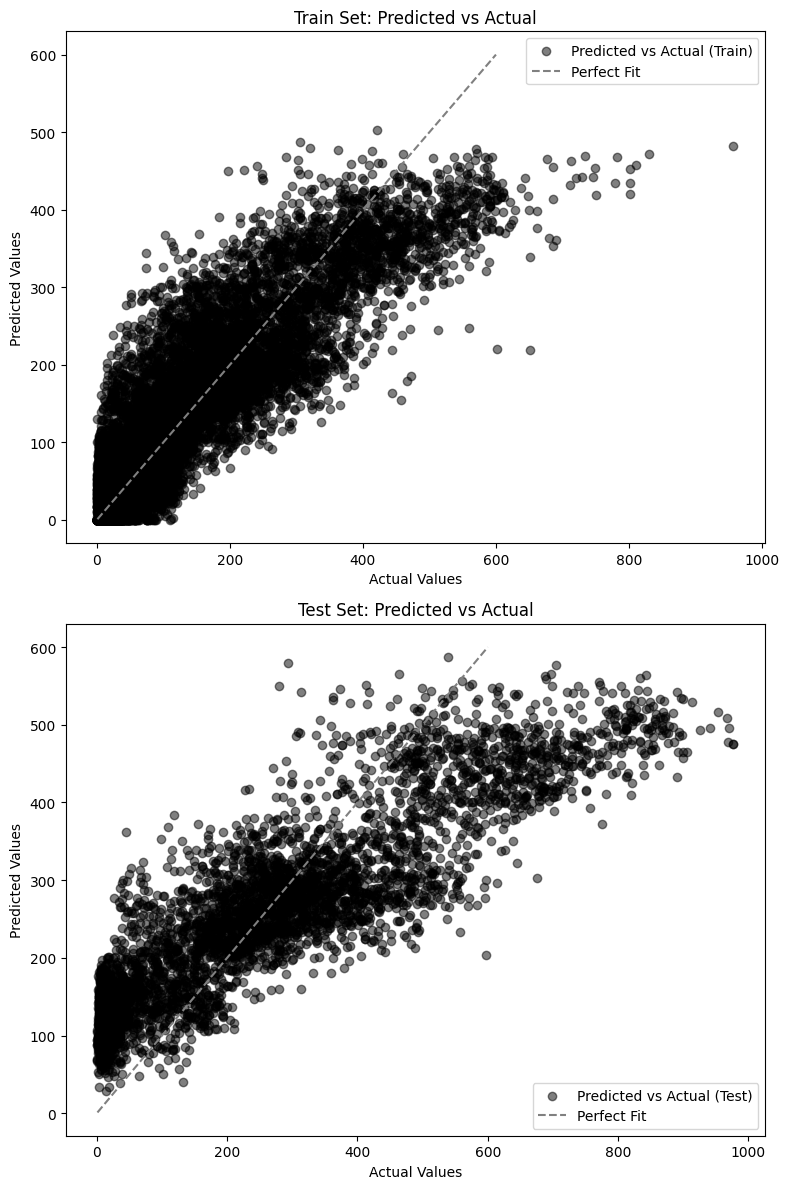

In [ ]:
# plot train and test Predicted VS actual values
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.scatter(y_train, lin_reg_train_preds, alpha=0.5, color="black", label="Predicted vs Actual (Train)")
plt.plot([min(y_train), 600], [min(y_train), 600], color="gray", linestyle="--", label="Perfect Fit")
plt.title("Train Set: Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(y_test, lin_reg_test_preds, alpha=0.5, color="black", label="Predicted vs Actual (Test)")
plt.plot([min(y_test), 600], [min(y_test), 600], color="gray", linestyle="--", label="Perfect Fit")
plt.title("Test Set: Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# testing performance with higher degree polynomials
degree = 2
poly = PolynomialFeatures(degree=degree)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression()

poly_reg.fit(X_train_poly, y_train)

# Predict on training and test data
y_train_poly_preds = poly_reg.predict(X_train_poly)
y_test_poly_preds = poly_reg.predict(X_test_poly)

y_train_poly_preds = np.maximum(y_train_poly_preds, 0)
y_test_poly_preds = np.maximum(y_test_poly_preds, 0)

# MAE for training and test sets
mae_train_poly = mean_absolute_error(y_train, y_train_poly_preds)
mae_test_poly = mean_absolute_error(y_test, y_test_poly_preds)

print(f"Polynomial Regression (Degree {degree})")
print(f"MAE (Train): {mae_train_poly}")
print(f"MAE (Test): {mae_test_poly}")



Polynomial Regression (Degree 2)
MAE (Train): 24.312184964383864
MAE (Test): 284.2315814233249


##Ridge regression

In [ ]:
# defining model
ridge_reg = Ridge(alpha = 0.1, fit_intercept = True)
# pipeline: standarizing and modelling
# here we use the default parameters as an initial step
ridge_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_reg', ridge_reg)
])
ridge_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge_reg', Ridge(alpha=0.1))])

In [ ]:
#MAE with standard parameters
y_train_pred = ridge_reg_pipe.predict(X_train)
print("MAE on training data:", mean_absolute_error(y_train, y_train_pred))

y_test_pred = ridge_reg_pipe.predict(X_test)
print("MAE on test data:", mean_absolute_error(y_test, y_test_pred))

MAE on training data: 52.55198483879849
MAE on test data: 103.11420723292622


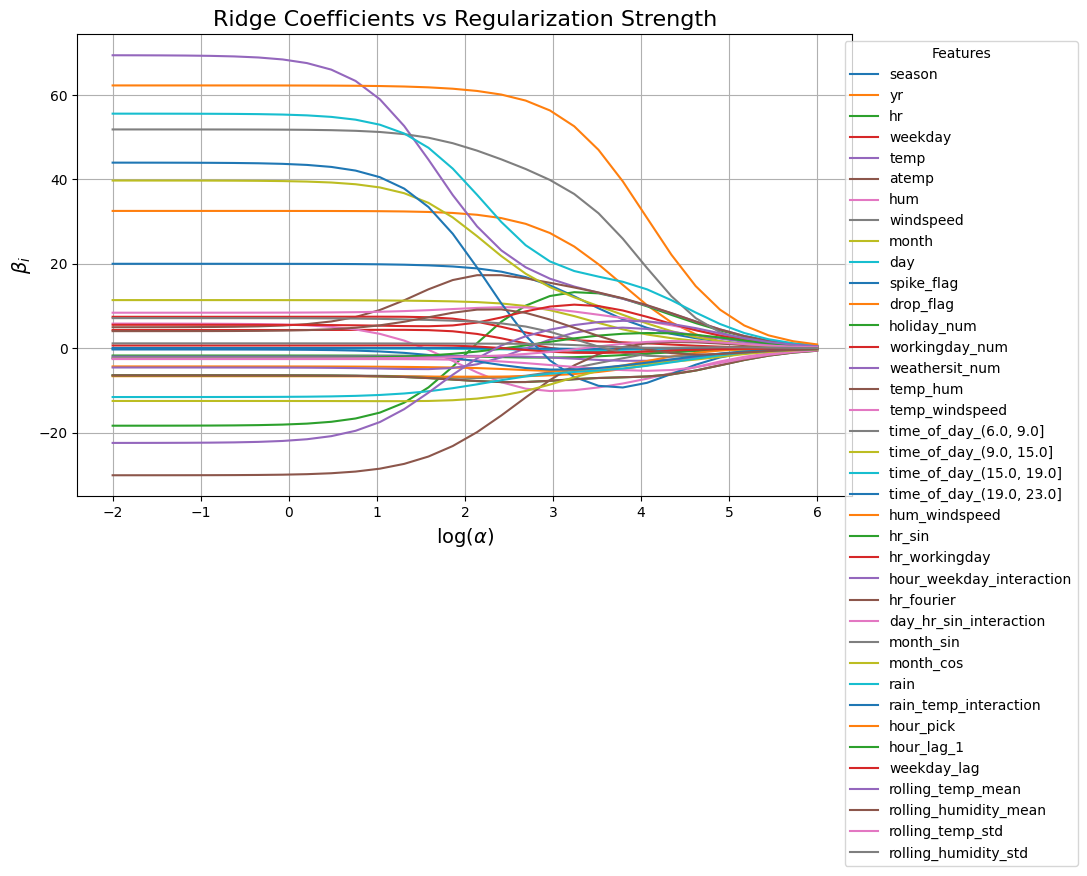

In [ ]:
# plot of alpha and beta
#  grid for alpha
ridge_reg_grid = np.geomspace(1e-2, 1e6, num=30)

# fit pipeline for each alpha
coefs = []  # List to store coefficients for each alpha
for alpha in ridge_reg_grid:
    ridge_reg_pipe.set_params(ridge_reg__alpha=alpha)
    ridge_reg_pipe.fit(X_train, y_train)
    coefs.append(ridge_reg_pipe.named_steps['ridge_reg'].coef_)

# turn to array
coefs = np.array(coefs).T

# Plotting the coefficients for all features
plt.figure(figsize=(10, 6))
for i, feature in enumerate(X_train.columns):
    plt.plot(np.log10(ridge_reg_grid), coefs[i], label=feature)

plt.xlabel("$\\log(\\alpha)$", fontsize=14)
plt.ylabel("$\\beta_i$", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title="Features")
plt.title("Ridge Coefficients vs Regularization Strength", fontsize=16)
plt.grid()
plt.show()

In [ ]:
#CV for Ridge
folds = KFold(n_splits = 10, random_state = 42, shuffle = True)
# hyperparameter grid
ridge_reg_params = {"ridge_reg__alpha" : ridge_reg_grid}
# cross-validating and fitting
ridgeCV = GridSearchCV(
    estimator = ridge_reg_pipe,
    param_grid = ridge_reg_params,
    scoring = "neg_mean_absolute_error",
    cv = folds
)
ridgeCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge_reg', Ridge(alpha=1000000.0))]),
             param_grid={'ridge_reg__alpha': array([1.00000000e-02, 1.88739182e-02, 3.56224789e-02, 6.72335754e-02,
       1.26896100e-01, 2.39502662e-01, 4.52035366e-01, 8.53167852e-01,
       1.61026203e+00, 3.03919538e+00, 5.73615251e+00, 1.08263673e+01,
       2.04335972e+01, 3.85662042e+01, 7.27895384e+01, 1.37382380e+02,
       2.59294380e+02, 4.89390092e+02, 9.23670857e+02, 1.74332882e+03,
       3.29034456e+03, 6.21016942e+03, 1.17210230e+04, 2.21221629e+04,
       4.17531894e+04, 7.88046282e+04, 1.48735211e+05, 2.80721620e+05,
       5.29831691e+05, 1.00000000e+06])},
             scoring='neg_mean_absolute_error')

In [ ]:
# selecting best model according to cv_err
mean_scores = -ridgeCV.cv_results_["mean_test_score"]
std_scores = ridgeCV.cv_results_["std_test_score"] / np.sqrt(ridgeCV.n_splits_)
alphas = ridgeCV.cv_results_["param_ridge_reg__alpha"].data

#defining threshold and one-standard error rule
best_index = np.argmin(mean_scores)
min_alpha_ridge = alphas[best_index]
threshold_ridge = mean_scores[best_index] + std_scores[best_index]
one_std_rule_alpha_ridge = np.max(alphas[mean_scores <= threshold_ridge])

print("Minimum alpha:", min_alpha_ridge)
print("1-SD alpha:", one_std_rule_alpha_ridge)
print("Best score for ridge:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 10.82636733874054
1-SD alpha: 489.3900918477489
Best score for ridge: 7.263976243910286


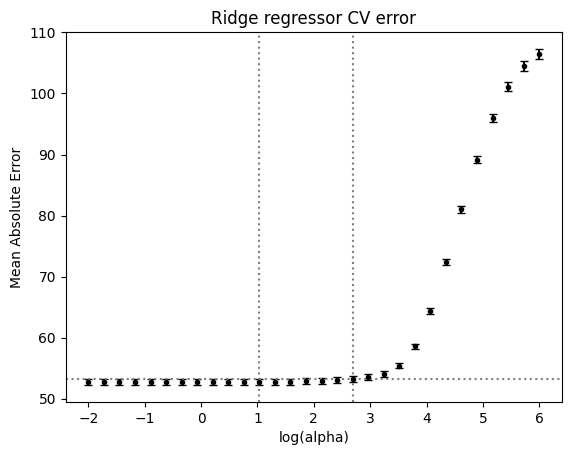

In [ ]:
#plotting cv
plt.errorbar(x=np.log10(ridge_reg_grid), y=mean_scores, yerr = std_scores, fmt='.', capsize=3, color='black')

#vertical line at the minimum CV MAE
plt.axvline(np.log10(min_alpha_ridge), ls='dotted', color="grey")
plt.axvline(np.log10(one_std_rule_alpha_ridge), ls='dotted', color="grey")
plt.axhline(threshold_ridge, ls='dotted', color="grey")

plt.title("Ridge regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Absolute Error')
plt.show()

In [ ]:
# ridge Model using best parameters

# refit best ridge model
ridge_reg_pipe.set_params(ridge_reg__alpha = one_std_rule_alpha_ridge)
ridge_reg_pipe.fit(X_train, y_train)

#MAE for training
y_train_pred = ridge_reg_pipe.predict(X_train)
mae_train_ridge = mean_absolute_error(y_train, y_train_pred)
print("MAE on training data:", mae_train_ridge)

# MAE for test
y_test_pred = ridge_reg_pipe.predict(X_test)
mae_test_ridge = mean_absolute_error(y_test, y_test_pred)
print("MAE on test data:", mae_test_ridge)

MAE on training data: 53.04680751222916
MAE on test data: 105.7324475730385


## Lasso Regression

In [ ]:
# defining model with alpha=0.1
lasso = Lasso(alpha = 0.1,  fit_intercept = True, tol=0.1)
# pipeline: standarization and modelling default parameters as initial step
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', lasso)
])
# fitting train
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, tol=0.1))])

In [ ]:
#Train and test errors with defalult parameters
y_train_pred = lasso_pipe.predict(X_train)
print("MAE on training data:", mean_absolute_error(y_train, y_train_pred))
y_test_pred = lasso_pipe.predict(X_test)
print("MAE on test data:", mean_absolute_error(y_test, y_test_pred))

MAE on training data: 52.987266972191826
MAE on test data: 103.84396046806306


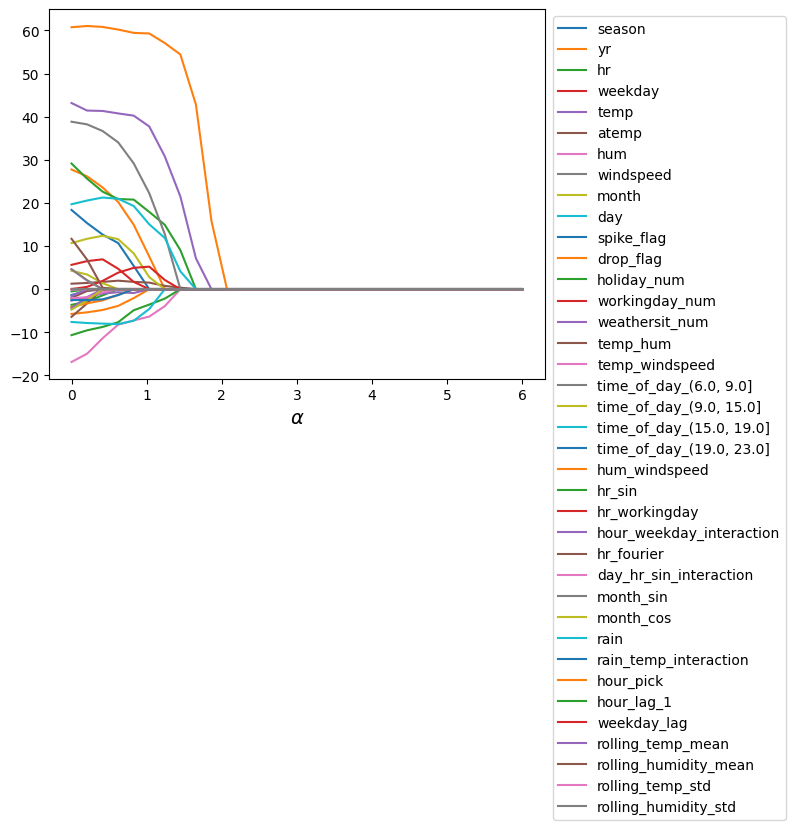

In [ ]:
#Plotting coefficients with default parameters
# grid
lasso_grid = 10**np.linspace(0, 6, num=30)
lasso_grid = np.geomspace(1, 1e6, num=30)

coefs = []
for alpha in lasso_grid:
    lasso_pipe.set_params(lasso__alpha=alpha)
    lasso_pipe.fit(X_train, y_train)
    coefs.append(lasso_pipe.named_steps['lasso'].coef_)

plt.plot(np.log10(lasso_grid), coefs)
plt.xlabel("$\\alpha$", fontsize = 14);
plt.legend(X_train.columns, loc='upper right', bbox_to_anchor = (1.5, 1))

In [ ]:
#CV for Lasso Regression

folds = KFold(n_splits = 10, random_state = 14, shuffle = True)
# using defined grid
params_lasso = {"lasso__alpha" : lasso_grid}
# cross-validating
lassoCV = GridSearchCV(
    estimator = lasso_pipe,
    param_grid = params_lasso,
    scoring = "neg_mean_absolute_error",
    cv = folds
)
# fitting CVs
lassoCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=14, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(alpha=1000000.0, tol=0.1))]),
             param_grid={'lasso__alpha': array([1.00000000e+00, 1.61026203e+00, 2.59294380e+00, 4.17531894e+00,
       6.72335754e+00, 1.08263673e+01, 1.74332882e+01, 2.80721620e+01,
       4.52035366e+01, 7.27895384e+01, 1.17210230e+02, 1.88739182e+02,
       3.03919538e+02, 4.89390092e+02, 7.88046282e+02, 1.26896100e+03,
       2.04335972e+03, 3.29034456e+03, 5.29831691e+03, 8.53167852e+03,
       1.37382380e+04, 2.21221629e+04, 3.56224789e+04, 5.73615251e+04,
       9.23670857e+04, 1.48735211e+05, 2.39502662e+05, 3.85662042e+05,
       6.21016942e+05, 1.00000000e+06])},
             scoring='neg_mean_absolute_error')

In [ ]:
# selecting best model that minimizes the cv_err
mean_scores = -lassoCV.cv_results_["mean_test_score"]
std_scores = lassoCV.cv_results_["std_test_score"] / np.sqrt(lassoCV.n_splits_)
alphas = lassoCV.cv_results_["param_lasso__alpha"].data

#one std-error rule
best_index = np.argmin(mean_scores)
min_alpha_lasso = alphas[best_index]
threshold_lasso = mean_scores[best_index] + std_scores[best_index]
one_std_rule_alpha_lasso = np.max(alphas[mean_scores <= threshold_lasso])

print("Minimum alpha:", min_alpha_lasso)
print("1-SD alpha:", one_std_rule_alpha_lasso)
print("Best score for lasso:", np.sqrt(np.min(mean_scores)))

Minimum alpha: 1.0
1-SD alpha: 1.6102620275609394
Best score for lasso: 7.34022465804899


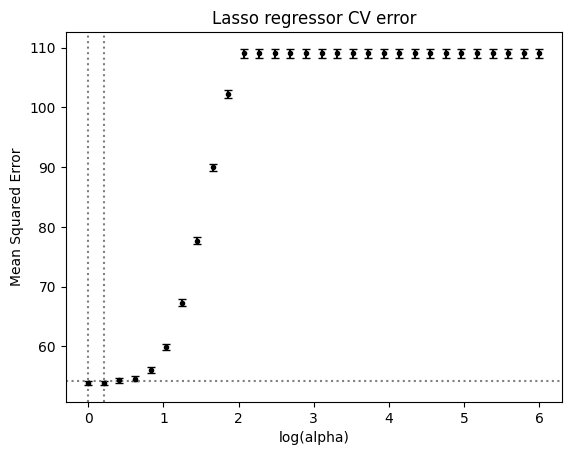

In [ ]:
# plotting cv for lasso
plt.errorbar(x=np.log10(lasso_grid), y=mean_scores, yerr = std_scores, fmt='.', capsize=3, color='black')

plt.axvline(np.log10(min_alpha_lasso), ls='dotted', color="grey")
plt.axvline(np.log10(one_std_rule_alpha_lasso), ls='dotted', color="grey")
plt.axhline(threshold_lasso, ls='dotted', color="grey")

plt.title("Lasso regressor CV error")
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best Lasso Model
# refit best lasso on whole training data
lasso_pipe.set_params(lasso__alpha = one_std_rule_alpha_lasso)
lasso_pipe.fit(X_train, y_train)

#MAE for train
y_train_pred = lasso_pipe.predict(X_train)
mae_train_lasso = mean_absolute_error(y_train, y_train_pred)
print("MAE on training data:", mae_train_lasso)

#MAE for test
y_test_pred = lasso_pipe.predict(X_test)
mae_test_lasso = mean_absolute_error(y_test, y_test_pred)
print("MAE on test data:", mae_test_lasso)

MAE on training data: 53.82480053203077
MAE on test data: 106.70662825058594


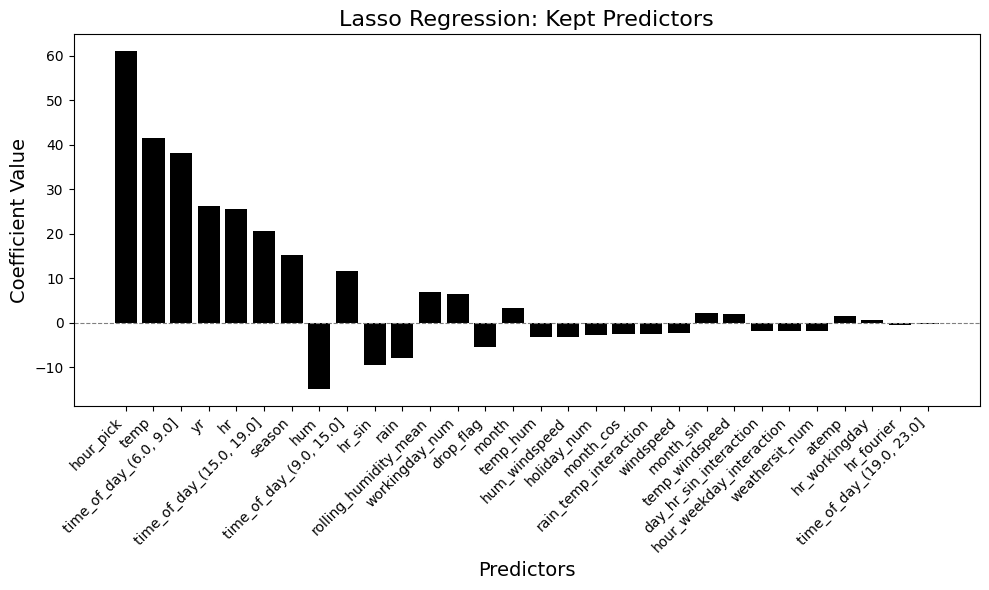

['weekday', 'day', 'spike_flag', 'hour_lag_1', 'weekday_lag', 'rolling_temp_mean', 'rolling_temp_std', 'rolling_humidity_std']


In [ ]:
#coefficients from Lasso
lasso_coefs = lasso_pipe.named_steps['lasso'].coef_

#better visualization
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_coefs
})

# predictors kept and ignored
kept_predictors = coef_df[coef_df['Coefficient'] != 0]
ignored_predictors = coef_df[coef_df['Coefficient'] == 0]['Feature'].tolist()

# sorting coefficients
kept_predictors = kept_predictors.sort_values(by='Coefficient', key=np.abs, ascending=False)

# plot for kept coefficients
plt.figure(figsize=(10, 6))
plt.bar(kept_predictors['Feature'], kept_predictors['Coefficient'], color='black')

plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlabel("Predictors", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=14)
plt.title("Lasso Regression: Kept Predictors", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

# list of ignored coefficients
print(ignored_predictors)

## K-Nearest Neighbors

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Pipeline with KNN and scaling
knn_pipe = Pipeline([("scaler", StandardScaler()),
                     ("kNN", KNeighborsRegressor())])

# Hyperparameters for GridSearchCV (tuning n_neighbors)
hyper_parameters = {"kNN__n_neighbors": np.arange(1, 30, 1)}

# GridSearchCV with cross-validation
knn_pipeCV = GridSearchCV(estimator=knn_pipe, param_grid=hyper_parameters,
                          scoring="neg_mean_absolute_error", cv=tscv)
knn_pipeCV.fit(X_train, y_train)

# Extract results from cross-validation
resCV_pipe = knn_pipeCV.cv_results_
pd.DataFrame(resCV_pipe)

# Compute "best" k value and its index
test_MAEs_pipe = -resCV_pipe["mean_test_score"]
std_test_MAEs_pipe = resCV_pipe["std_test_score"] / np.sqrt(knn_pipeCV.n_splits_)
k_grid_pipe = resCV_pipe["param_kNN__n_neighbors"]

# Get best k and its test error
index_best_pipe = np.argmin(test_MAEs_pipe)  # Index of the best k
best_k_cv_pipe = k_grid_pipe[index_best_pipe]
best_test_score = test_MAEs_pipe[index_best_pipe]

# Print the best k value and its mean test score (MAE)
print(f"Best k={best_k_cv_pipe} with mean test score (MAE)={best_test_score:.4f}")

# Apply the one-standard deviation rule to select k within one std dev of best test MAE
one_std_rule_best_k_cv_pipe = np.max(k_grid_pipe[test_MAEs_pipe <= test_MAEs_pipe[index_best_pipe] + std_test_MAEs_pipe[index_best_pipe]])
print(f"One std deviation rule: k={one_std_rule_best_k_cv_pipe}")

# Final model training with the selected k value using one std deviation rule
knn_final_pipe_best_k = KNeighborsRegressor(n_neighbors=best_k_cv_pipe)

# Fit the model on training data
knn_final_pipe_best_k.fit(X_train, y_train)

# Predict on train set and calculate training MAE
y_train_pred_pipe = knn_final_pipe_best_k.predict(X_train)
mae_train_pipe_best_k = mean_absolute_error(y_train, y_train_pred_pipe)
print(f"Train set MAE with best k={best_k_cv_pipe}: {mae_train_pipe_best_k:.4f}")

# Predict on test set and calculate test MAE for best k
y_test_pred_pipe_best_k = knn_final_pipe_best_k.predict(X_test)
mae_test_pipe_best_k = mean_absolute_error(y_test, y_test_pred_pipe_best_k)
print(f"Test set MAE with best k={best_k_cv_pipe}: {mae_test_pipe_best_k:.4f}")

# print the cross-validation scores (average score across folds)
cv_scores = -resCV_pipe["mean_test_score"]
print(f"Cross-validation mean MAE: {np.mean(cv_scores):.4f}")


Best k=5 with mean test score (MAE)=53.3619
One std deviation rule: k=11
Train set MAE with best k=5: 40.1077
Test set MAE with best k=5: 112.2978
Cross-validation mean MAE: 57.0556


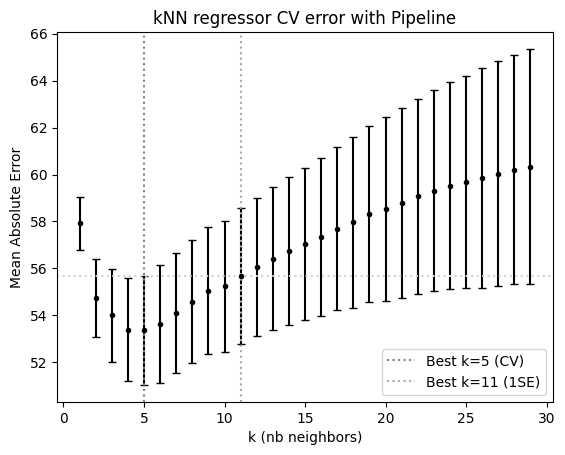

In [ ]:
import matplotlib.pyplot as plt
#plot
plt.errorbar(x=k_grid_pipe, y=test_MAEs_pipe, yerr=std_test_MAEs_pipe, fmt='.', capsize=3, color='black')

plt.axvline(best_k_cv_pipe, ls='dotted', color="grey", label=f'Best k={best_k_cv_pipe} (CV)')

plt.axvline(one_std_rule_best_k_cv_pipe, ls='dotted', color="darkgrey", label=f'Best k={one_std_rule_best_k_cv_pipe} (1SE)')

plt.axhline(test_MAEs_pipe[index_best_pipe] + std_test_MAEs_pipe[index_best_pipe], ls='dotted', color="lightgrey")

# Title and labels
plt.title("kNN regressor CV error with Pipeline", color='black')
plt.xlabel('k (nb neighbors)', color='black')
plt.ylabel('Mean Absolute Error', color='black')

plt.legend()
plt.show()


## Gradient Boosting Regressor

### CV with time series split

#### Full Data

In [ ]:
# CV for parameter tunning

gbrt = GradientBoostingRegressor(random_state=42, warm_start=True, loss="absolute_error")

param_grid = {
    'n_estimators': [200, 250, 300],
    'learning_rate': [0.05, 0.055, 0.1],
    'max_depth': [6, 7, 8, None],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [1, 2, 3]}
# Time series split consistent with time series nature of data
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
grid_search = GridSearchCV(
    estimator=gbrt,
    param_grid=param_grid,
    cv=tscv,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)
#using the entire data to find best parameters
grid_search.fit(X_train, y_train)
train_gb = -grid_search.best_score_
# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score (MAE):", -grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
Best score (MAE): 53.943402854721114


In [ ]:
# Best parameters
best_params = grid_search.best_params_

# Define the GradientBoostingRegressor with the best hyperparameters
best_gbrt = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Train the model using the best parameters
best_gbrt.fit(X_train, y_train)

# Predict on the test data
y_pred_test_gb = best_gbrt.predict(X_test)

# Calculate the Mean Absolute Error on the test set
test_mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
print(f"Test MAE: {test_mae_gb:.4f}")

Test MAE: 66.8402


In [ ]:
best_gbrt = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42
)

# Train the model using the best parameters
best_gbrt.fit(X_train, y_train)

# Predict on the test data
y_pred_test_gb = best_gbrt.predict(X_test)

# Calculate the Mean Absolute Error on the test set
test_mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
print(f"Test MAE: {test_mae_gb:.4f}")

Test MAE: 64.6286


#### Restricted Data

As GradientBoostingRegressor does not offer built-in L1 or L2 regularization. This can make it more prone to overfitting when irrelevant or noisy features are present. We will train the model using restricted data (computed before after asserting correlations matrix). To make it more computational efficiency we will use RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

grid_search_restricted = RandomizedSearchCV(
    estimator=gbrt,
    param_distributions=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search_restricted.fit(X_train_restricted, y_train_restricted)

train_gb_restricted = -grid_search_restricted.best_score_

# Best parameters and score
print("Best parameters:", grid_search_restricted.best_params_)
print("Best score (MAE):", -grid_search_restricted.best_score_)

best_params_restricited = grid_search_restricted.best_params_

best_gbrt_restricted = GradientBoostingRegressor(
    n_estimators=best_params_restricited['n_estimators'],
    learning_rate=best_params_restricited['learning_rate'],
    max_depth=best_params_restricited['max_depth'],
    min_samples_split=best_params_restricited['min_samples_split'],
    min_samples_leaf=best_params_restricited['min_samples_leaf'],
    random_state=42
)

best_gbrt_restricted.fit(X_train_restricted, y_train_restricted)

y_pred_test_gb_restricted = best_gbrt_restricted.predict(X_test_restricted)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 7, 'learning_rate': 0.05}
Best score (MAE): 57.50477986539942


In [ ]:
# Calculate the Mean Absolute Error on the test set
test_mae_gb_restricted = mean_absolute_error(y_test_restricted, y_pred_test_gb_restricted)
print(f"Test MAE: {test_mae_gb_restricted:.4f}")

Test MAE: 54.7070


## Trees

### Decision Trees

In [ ]:
#fully grown decision tree with absolute_error as loss function
dt_model = DecisionTreeRegressor(random_state=42, max_depth=None, criterion='absolute_error')
dt_model.fit(X_train, y_train)
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)
mae_train_dt = mean_absolute_error(y_train, y_pred_train_dt)
mae_test_dt = mean_absolute_error(y_test, y_pred_test_dt)

print(f"Decision Tree Train MAE: {mae_train_dt}")
print(f"Decision Tree Test MAE: {mae_test_dt}")

Decision Tree Train MAE: 0.0
Decision Tree Test MAE: 76.84057971014492


In [ ]:
#fully grown 100 random forest trees
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=None
)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)

print(f"Random Forest Train MAE: {mae_train_rf}")
print(f"Random Forest Test MAE: {mae_test_rf}")

Random Forest Train MAE: 7.79368188235294
Random Forest Test MAE: 56.153836187966625


In [ ]:
#same base estimator used for decison tree
base_estimator = DecisionTreeRegressor(random_state=42, max_depth=None, criterion='absolute_error')
#apply a bootstrap aggregation
bagging_model = BaggingRegressor(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42,
    max_samples=0.8,
)

bagging_model.fit(X_train, y_train)
y_pred_train_bagging = bagging_model.predict(X_train)
y_pred_test_bagging = bagging_model.predict(X_test)

mae_train_bagging = mean_absolute_error(y_train, y_pred_train_bagging)
mae_test_bagging = mean_absolute_error(y_test, y_pred_test_bagging)

print(f"Bagging Train MAE: {mae_train_bagging}")
print(f"Bagging Test MAE: {mae_test_bagging}")

Bagging Train MAE: 9.952037176470588
Bagging Test MAE: 58.31218489240227


               Train MAE   Test MAE
Decision Tree   0.000000  76.840580
Random Forest   7.793682  56.153836
Bagging         9.952037  58.312185


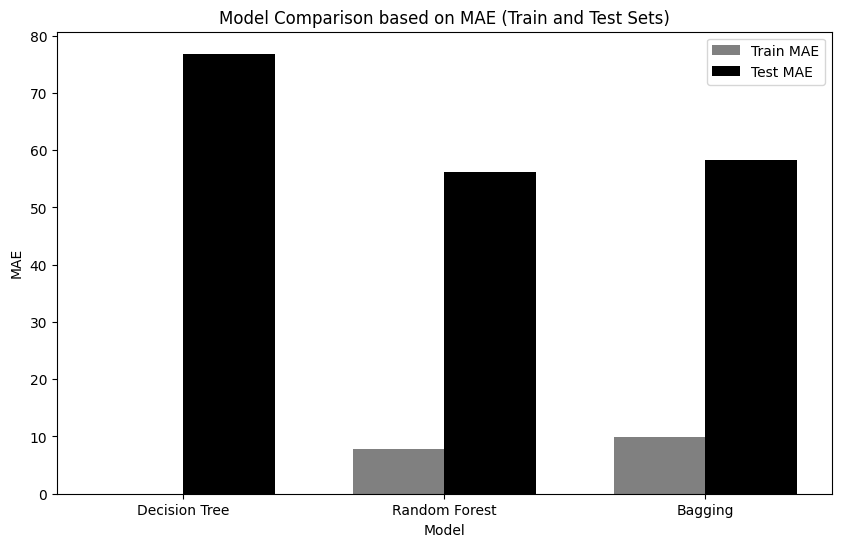

In [ ]:
#MAE results for the base models
results = {
    "Decision Tree": {"Train MAE": mae_train_dt, "Test MAE": mae_test_dt},
    "Random Forest": {"Train MAE": mae_train_rf, "Test MAE": mae_test_rf},
    "Bagging": {"Train MAE": mae_train_bagging, "Test MAE": mae_test_bagging}
}
results_df = pd.DataFrame(results).T
print(results_df)
#comparison of performances in terms of MAE on train and test sets
width = 0.35  #width of the bars
x_pos = np.arange(len(results_df.index))
fig, ax = plt.subplots(figsize=(10, 6))
#train MAE
rects1 = ax.bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', color='grey')
#test MAE
rects2 = ax.bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', color='black')
ax.set_ylabel("MAE")
ax.set_xlabel("Model")
ax.set_title("Model Comparison based on MAE (Train and Test Sets)")
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df.index)
ax.legend()
plt.show()

### Best Base Tree (CV)

In [ ]:
#folds
folds = KFold(n_splits=10, random_state=42, shuffle=True)
#hyperparameter grid to tune the regressor
tree_param_grid = {
    "max_depth": [None], #we keep max_depth == none as it is going to be used in bagging and RF
    # where we want to have a low bias and reduce teh variance by boostrapping!!!!!
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 6],
    "criterion": ["absolute_error"]
}

tree_regressor = DecisionTreeRegressor(random_state=42)

#CV and fitting
treeCV = GridSearchCV(
    estimator=tree_regressor,
    param_grid=tree_param_grid,
    scoring="neg_mean_absolute_error",
    cv=folds,
    n_jobs=-1
)
treeCV.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [None],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_absolute_error')

In [ ]:
#extracting best model and scores
mean_scores = -treeCV.cv_results_["mean_test_score"]
std_scores = treeCV.cv_results_["std_test_score"] /np.sqrt(treeCV.cv.n_splits)
params = treeCV.cv_results_["param_max_depth"].data

best_index = np.argmin(mean_scores)
best_max_depth = treeCV.cv_results_["param_max_depth"].data[best_index]
threshold_tree = mean_scores[best_index] + std_scores[best_index]
print("Best score for decision tree:", np.sqrt(np.min(mean_scores)))

Best score for decision tree: 5.2621425839287195


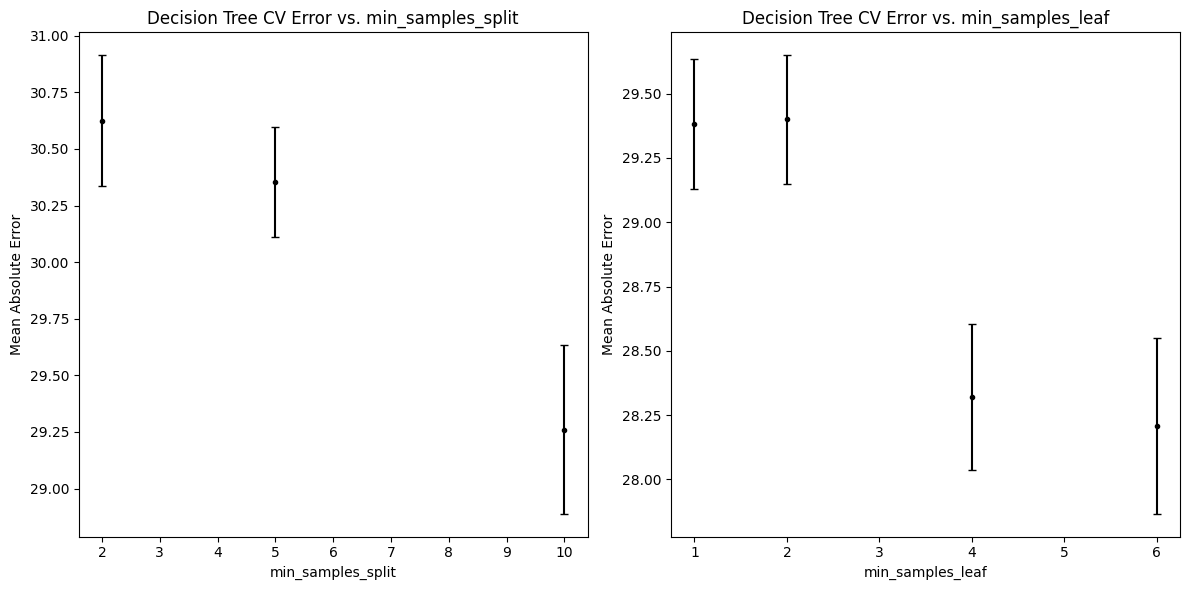

In [ ]:
#unique values for min_samples_split and min_samples_leaf
min_samples_splits = treeCV.cv_results_['param_min_samples_split'].data
min_samples_splits = np.unique(min_samples_splits[~np.isnan(min_samples_splits)])

min_samples_leafs = treeCV.cv_results_['param_min_samples_leaf'].data
min_samples_leafs = np.unique(min_samples_leafs[~np.isnan(min_samples_leafs)])
#plotting error vs min_sample_leaf and min_sample_split
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].errorbar(x=min_samples_splits,
                 y=mean_scores[:len(min_samples_splits)],
                 yerr=std_scores[:len(min_samples_splits)],
                 fmt='.', capsize=3, color='black')
axes[0].set_title("Decision Tree CV Error vs. min_samples_split")
axes[0].set_xlabel('min_samples_split')
axes[0].set_ylabel('Mean Absolute Error')

axes[1].errorbar(x=min_samples_leafs,
                 y=mean_scores[len(min_samples_splits):len(min_samples_splits) + len(min_samples_leafs)],
                 yerr=std_scores[len(min_samples_splits):len(min_samples_splits) + len(min_samples_leafs)],
                 fmt='.', capsize=3, color='black')
axes[1].set_title("Decision Tree CV Error vs. min_samples_leaf")
axes[1].set_xlabel('min_samples_leaf')
axes[1].set_ylabel('Mean Absolute Error')

plt.tight_layout()
plt.show()

In [ ]:
#best hyperparameters from the plot above
best_max_depth = None
best_min_samples_leaf = 6
best_min_samples_split = 10

#refit a Decision Tree model using the best hyperparameters
best_tree_model = DecisionTreeRegressor(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    min_samples_split=best_min_samples_split,
    random_state=42,
    criterion='absolute_error'
)
best_tree_model.fit(X_train, y_train)
y_train_pred = best_tree_model.predict(X_train)
y_test_pred = best_tree_model.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best min_samples_split: {best_min_samples_split}")
#print(f"Best score for decision tree (RMSE): {np.sqrt(np.min(mean_scores))}")
print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")


Best max_depth: None
Best min_samples_leaf: 6
Best min_samples_split: 10
Train MAE: 15.380517647058824
Test MAE: 78.51262626262626


In [ ]:
#saving for final tabel
mae_test_best_decision_tree = mae_test
mae_train_best_decision_tree = mae_train


### Bagging

For bagging we will use the best tree coming from the CV!! (fully grown as we want min bias and reduce the var with boostrap!)

#### Entire Feature Space

In [ ]:
B = [2,5,10,25,50,100] #number on estimators to use for bagging

# saving model, oob_prediction_ and its std
bagging_models = []
bagging_oob_predictions_list = []
bagging_oob_std_list = []
#computational cost list
bagging_fitting_time_list = []
#saving an aggregated feature importance list
bagging_feature_importances_list = []
i = 0

for n_estimators in B: # loop to fit different decision tree (fully grown) and bootstrapped with B = [....]
    i += 1
    print(f'We are at step...{i}')
    model = BaggingRegressor(
        estimator=best_tree_model,
        n_estimators=n_estimators,
        max_samples=0.67, # selecting 80% of samples for variance reduction
        max_features=1.0, #use all features
        oob_score=True, #make sure to activate the oob score
        random_state=42,
        bootstrap = True #by defualt bagging (sample with replacement).. better specify it
    )
    #track intial time
    start_time = time.time()
 #fit  of the ith iteration
    model.fit(X, y)  # USING THE ALL FEATURE SPACE
    # compute fitting time
    fitting_time = time.time() - start_time

# store model oob_errors and oob_std in teh respective lists
    bagging_models.append(model)
    if hasattr(model, 'oob_prediction_'): #check if mthe b-th model has oob attribute
        bagging_oob_predictions_list.append(model.oob_prediction_)
        oob_std_dev = np.std(model.oob_prediction_)
    else: #if error occurs
        bagging_oob_predictions_list.append(None)
        oob_std_dev = 0
    bagging_oob_std_list.append(oob_std_dev)

#store average of teh feature importance of all teh B trees built at the bth iteration
    feature_importances = np.mean([tree.feature_importances_ for tree in model.estimators_],axis=0)
    bagging_feature_importances_list.append(feature_importances)
    bagging_fitting_time_list.append(fitting_time)

We are at step...1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...3


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...4
We are at step...5
We are at step...6


OOB Error (MAE) for B=2: 70.4200, Fitting Time: 11.08
OOB Error (MAE) for B=5: 35.4529, Fitting Time: 31.91
OOB Error (MAE) for B=10: 28.1279, Fitting Time: 59.02
OOB Error (MAE) for B=25: 26.8312, Fitting Time: 147.97
OOB Error (MAE) for B=50: 26.4252, Fitting Time: 289.65
OOB Error (MAE) for B=100: 26.1509, Fitting Time: 583.90


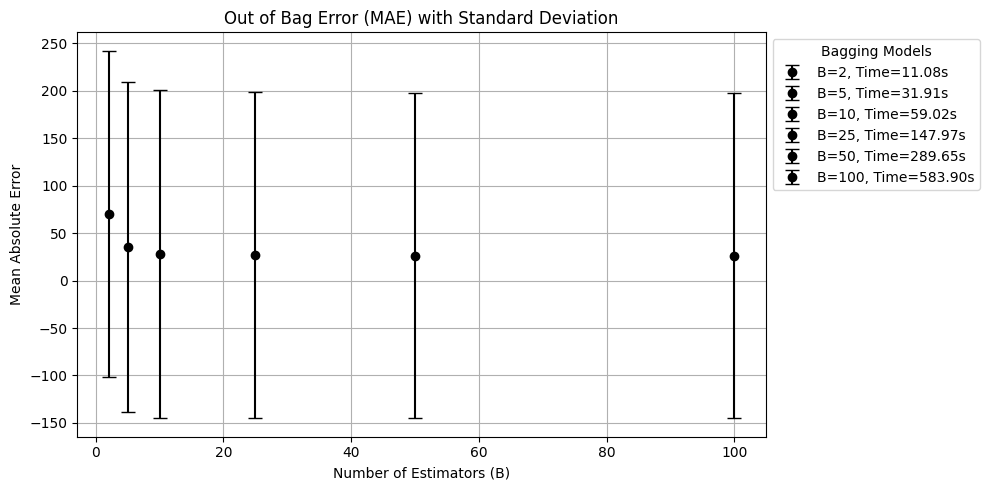

In [ ]:
# plot for oob and computational cost
plt.figure(figsize=(10, 5))

#bagging_oob_mae_list
bagging_oob_mae_list = []

for i, n_estimators in enumerate(B): #extract all data obtained by OOb iteration
    oob_mae = mean_absolute_error(y, bagging_oob_predictions_list[i])
    bagging_oob_mae_list.append(oob_mae)
    oob_std_dev = bagging_oob_std_list[i]
    fitting_time = abs(bagging_fitting_time_list[i]) # get the computational cost for the current B
    #error bar for the current b with b from 1 to B
    print(f'OOB Error (MAE) for B={n_estimators}: {oob_mae:.4f}, Fitting Time: {fitting_time:.2f}')
    plt.errorbar(n_estimators, oob_mae, yerr=oob_std_dev, fmt='o', capsize=5, label=f'B={n_estimators}, Time={fitting_time:.2f}s', color='black')

plt.xlabel('Number of Estimators (B)')
plt.ylabel('Mean Absolute Error')
plt.title('Out of Bag Error (MAE) with Standard Deviation')
plt.grid()
plt.legend(title="Bagging Models", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
#fitting the best bagging model
B = 50
#the rest has been already described before
best_bagging_full_feature_model = BaggingRegressor(
    estimator=best_tree_model,
    n_estimators=B,
    max_samples=0.67,
    max_features=1.0,
    oob_score=True,
    random_state=42,
    bootstrap=True
)

best_bagging_full_feature_model.fit(X, y)

if hasattr(model, 'oob_prediction_'):
    oob_predictions = model.oob_prediction_
    oob_mae = np.mean(np.abs(oob_predictions - y))
    oob_std_dev = np.std(oob_predictions)
else:
    oob_mae = 0
    oob_std_dev = 0

# Output results
print(f"OOB MAE for B = {B}: {oob_mae:.4f}")
print(f"OOB Std Dev for B = {B}: {oob_std_dev:.4f}")

OOB MAE for B = 50: 26.1509
OOB Std Dev for B = 50: 171.3156


In [ ]:
#save mae for final table

######################## for final table ################
train_predictions_bag = best_bagging_full_feature_model.predict(X)
train_mae_bag = mean_absolute_error(train_predictions_bag,y)
best_bagging_full_feature_model_test_mae = oob_mae
best_bagging_full_feature_model_train_mae = train_mae_bag
print(f'Train MAE: {best_bagging_full_feature_model_train_mae}')
print(f'Test MAE: {best_bagging_full_feature_model_test_mae}')

Train MAE: 20.734827722511366
Test MAE: 26.150884718681983


In [ ]:
#average the feature importance for each model with different B
average_feature_importances = np.mean(bagging_feature_importances_list, axis=0)
importances_df = pd.DataFrame({
    "Feature": X_train.columns, #FEATURE IMPORTANCE WITH ALL FEATURES
    "Average Importance": average_feature_importances
})
#sort and print the result
importances_df = importances_df.sort_values(by="Average Importance", ascending=False)
print(importances_df)


                     Feature  Average Importance
2                         hr            0.308833
31                 hour_pick            0.137332
4                       temp            0.135327
1                         yr            0.083064
23             hr_workingday            0.036687
32                hour_lag_1            0.031124
22                    hr_sin            0.023952
25                hr_fourier            0.022703
5                      atemp            0.021969
34         rolling_temp_mean            0.021178
24  hour_weekday_interaction            0.016864
13            workingday_num            0.015883
0                     season            0.015611
6                        hum            0.014470
3                    weekday            0.010764
26    day_hr_sin_interaction            0.010247
8                      month            0.008741
35     rolling_humidity_mean            0.008383
36          rolling_temp_std            0.007494
27                 m

In [ ]:
#get the last 20 features for importance and drop them to check the influence on the next cells
least_important_features = importances_df['Feature'].tail(20)
X_dropped_bagging = X.drop(columns=least_important_features)

# Optionally, print the dropped features and the new shape of X_dropped_bagging
print("Dropped features:")
print(least_important_features)
print("New shape of X_dropped_bagging:", X_dropped_bagging.shape)

Dropped features:
36            rolling_temp_std
27                   month_sin
15                    temp_hum
37        rolling_humidity_std
18     time_of_day_(9.0, 15.0]
14              weathersit_num
33                 weekday_lag
21               hum_windspeed
28                   month_cos
9                          day
17      time_of_day_(6.0, 9.0]
16              temp_windspeed
29                        rain
30       rain_temp_interaction
11                   drop_flag
7                    windspeed
19    time_of_day_(15.0, 19.0]
20    time_of_day_(19.0, 23.0]
12                 holiday_num
10                  spike_flag
Name: Feature, dtype: object
New shape of X_dropped_bagging: (15179, 18)


#### Reduced Feature Space

Here we decided to reduce the feature space differently than we did before (using correlation matrix). The reason is that we leave the algorith itself decide which features are the most important, hence we avoid any form of human bias and let the decision to be taken by the "eye of the model"

In [ ]:
B = [2,5,10,25,50,100] #number on estimators to use for bagging

# saving model, oob_prediction_ and its std
bagging_models = []
bagging_oob_predictions_list = []
bagging_oob_std_list = []
#computational cost list
bagging_fitting_time_list = []
#saving an aggregated feature importance list
bagging_feature_importances_list = []
i = 0

for n_estimators in B: # loop to fit different decision tree (fully grown) and bootstrapped with B = [....]
    i += 1
    print(f'We are at step...{i}')
    model = BaggingRegressor(
        estimator=best_tree_model,
        n_estimators=n_estimators,
        max_samples=0.67, # selecting 80% of samples for variance reduction
        max_features=1.0, #use all features
        oob_score=True, #make sure to activate the oob score
        random_state=42,
        bootstrap = True #by defualt bagging (sample with replacement).. better specify it
    )
    #track intial time
    start_time = time.time()
 #fit  of the ith iteration
    model.fit(X_dropped_bagging, y)  # USING THE ALL FEATURE SPACE
    # compute fitting time
    fitting_time = time.time() - start_time

# store model oob_errors and oob_std in teh respective lists
    bagging_models.append(model)
    if hasattr(model, 'oob_prediction_'): #check if mthe b-th model has oob attribute
        bagging_oob_predictions_list.append(model.oob_prediction_)
        oob_std_dev = np.std(model.oob_prediction_)
    else: #if error occurs
        bagging_oob_predictions_list.append(None)
        oob_std_dev = 0
    bagging_oob_std_list.append(oob_std_dev)

#store average of teh feature importance of all teh B trees built at the bth iteration
    feature_importances = np.mean([tree.feature_importances_ for tree in model.estimators_],axis=0)
    bagging_feature_importances_list.append(feature_importances)
    bagging_fitting_time_list.append(fitting_time)

We are at step...1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...3


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1314: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


We are at step...4
We are at step...5
We are at step...6


OOB Error (MAE) for B=2: 70.7616, Fitting Time: 6.33
OOB Error (MAE) for B=5: 36.0354, Fitting Time: 14.54
OOB Error (MAE) for B=10: 28.9454, Fitting Time: 31.51
OOB Error (MAE) for B=25: 27.7199, Fitting Time: 72.82
OOB Error (MAE) for B=50: 27.2621, Fitting Time: 155.04
OOB Error (MAE) for B=100: 27.0331, Fitting Time: 298.90


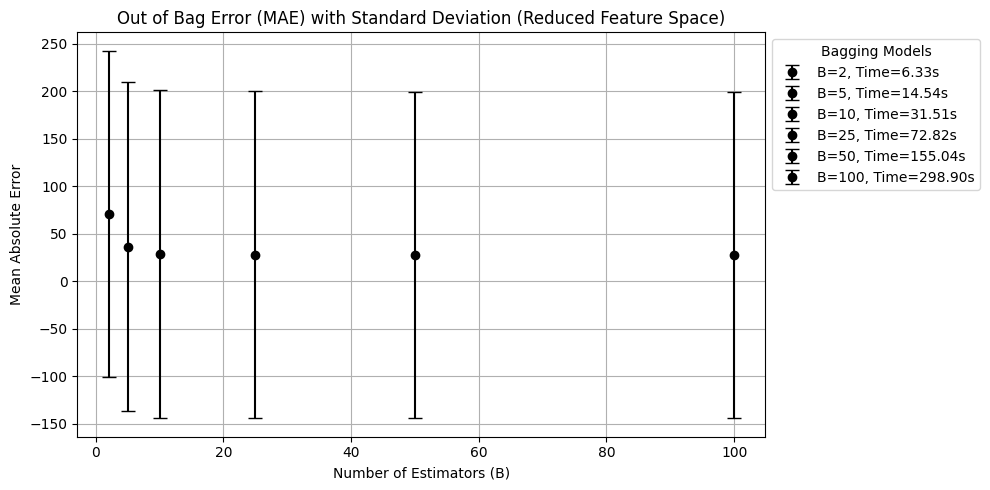

In [ ]:
# plot for oob and computational cost
plt.figure(figsize=(10, 5))

#bagging_oob_mae_list
bagging_oob_mae_list = []

for i, n_estimators in enumerate(B): #extract all data obtained by OOb iteration
    oob_mae = mean_absolute_error(y, bagging_oob_predictions_list[i])
    bagging_oob_mae_list.append(oob_mae)
    oob_std_dev = bagging_oob_std_list[i]
    fitting_time = abs(bagging_fitting_time_list[i]) # get the computational cost for the current B
    #error bar for the current b with b from 1 to B
    print(f'OOB Error (MAE) for B={n_estimators}: {oob_mae:.4f}, Fitting Time: {fitting_time:.2f}')
    plt.errorbar(n_estimators, oob_mae, yerr=oob_std_dev, fmt='o', capsize=5, label=f'B={n_estimators}, Time={fitting_time:.2f}s', color='black')

plt.xlabel('Number of Estimators (B)')
plt.ylabel('Mean Absolute Error')
plt.title('Out of Bag Error (MAE) with Standard Deviation (Reduced Feature Space)')
plt.grid()
plt.legend(title="Bagging Models", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
#fitting the best bagging model
B = 50
#the rest has been already described before!!!
best_bagging_full_feature_model = BaggingRegressor(
    estimator=best_tree_model,
    n_estimators=B,
    max_samples=0.67,
    max_features=1.0,
    oob_score=True,
    random_state=42,
    bootstrap=True
)

best_bagging_full_feature_model.fit(X, y)

if hasattr(model, 'oob_prediction_'):
    oob_predictions = model.oob_prediction_
    oob_mae = np.mean(np.abs(oob_predictions - y))
    oob_std_dev = np.std(oob_predictions)
else:
    oob_mae = 0
    oob_std_dev = 0

# Output results
print(f"OOB MAE for B = {B}: {oob_mae:.4f}")
print(f"OOB Std Dev for B = {B}: {oob_std_dev:.4f}")



OOB MAE for B = 50: 27.0331
OOB Std Dev for B = 50: 171.5297


In [ ]:
#save mae for final table

######################## for final table ################
train_predictions_bag_red = best_bagging_full_feature_model.predict(X)
train_mae_bag_red = mean_absolute_error(train_predictions_bag_red,y)
best_bagging_reduced_feature_model_test_mae = oob_mae
best_bagging_reduced_feature_model_train_mae = train_mae_bag_red
print(f'Train MAE: {best_bagging_full_feature_model_train_mae}')
print(f'Test MAE: {best_bagging_full_feature_model_test_mae}')

Train MAE: 20.734827722511366
Test MAE: 26.150884718681983


In [ ]:
#manually saving results not to lose them in case of something

#do not run, do only if you dont wanna wait the CV!!!!!!!!

best_bagging_full_feature_model_train_mae = 20.734827722511366
best_bagging_full_feature_model_test_mae = 26.150884718681983
best_bagging_reduced_feature_model_train_mae = 20.734827722511366
best_bagging_reduced_feature_model_test_mae = 26.150884718681983

### Random Forest

#### Why RF is Better

##### Full Dataset

In [ ]:
#base models RF and bagging
rfr = RandomForestRegressor(n_estimators=50, max_features=int(X_train.shape[1]/3), oob_score=True, warm_start=True, random_state=1)
bagging = RandomForestRegressor(n_estimators=50, max_features=None, oob_score=True, warm_start=True, random_state=1)
# store oob errors
oob_rfr, oob_bag = list(), list()

#loop through number of estimators from 3 to 500
for i in range(50, 500):
    # fir rf
    rfr.set_params(n_estimators=i)
    rfr.fit(X, y)
    oob_rfr.append(1 - rfr.oob_score_)

    #fit bagging
    bagging.set_params(n_estimators=i)
    bagging.fit(X, y)
    oob_bag.append(1 - bagging.oob_score_)
    print(f'Step {i}')

Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Step 123
Step 124
Step 125
Step 126
Step 127
Step 128
Step 129
Step 130
Step 131
Step 132
Step 133
Step 134
Step 135
Step 136
Step 137
Step 138
Step 139
Step 140
Step 141
Step 142
Step 143
Step 144
Step 145
Step 146
Step 147
Step 148
Step 149
Step 150
Step 151
Step 152
Step 153
Step 154
Step 155
Step 156
Step 157
Step 158
Step 159
Step 160
Step 161
Step 162
Step 163
Step 164
Step 165
Step 1

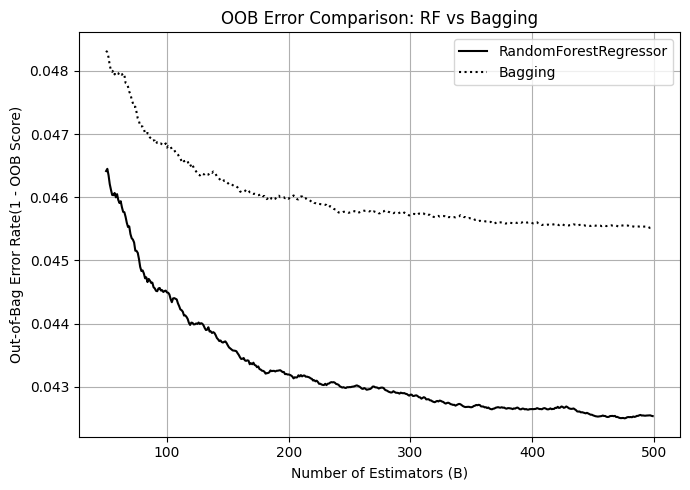

In [ ]:
#OOB errors
plt.figure(figsize=(7, 5))
plt.plot(range(50, 500), oob_rfr, label='RandomForestRegressor', color='black',)
plt.plot(range(50, 500), oob_bag, label='Bagging', color='black',linestyle = ':' )
plt.xlabel('Number of Estimators (B)')
plt.ylabel('Out-of-Bag Error Rate(1 - OOB Score)')
plt.title('OOB Error Comparison: RF vs Bagging')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Reduced Dataset

In [ ]:
#repeating for the reduced dataset, this time we save the OOb mae and also teh fitting time for curiosity
rfr = RandomForestRegressor(n_estimators=50, max_features=int(X_train.shape[1]/3), oob_score=True, warm_start=True, random_state=1)
bagging = RandomForestRegressor(n_estimators=50, max_features=None, oob_score=True, warm_start=True, random_state=1)

oob_rfr_reduced, oob_bag_reduced = list(), list()
computational_cost_rfr, computational_cost_bag = list(), list()

for i in range(50, 500):
    #start time for rf
    start_time_rfr = time.time()
    rfr.set_params(n_estimators=i)
    rfr.fit(X_dropped_bagging, y)
    oob_predictions_rfr = rfr.oob_prediction_
    oob_mae_rfr = np.mean(np.abs(oob_predictions_rfr - y))
    oob_rfr_reduced.append(oob_mae_rfr)
  #end time for rf and elapsed time
    end_time_rfr = time.time()
    computational_cost_rfr.append(end_time_rfr - start_time_rfr)
    #start time for Bagging
    start_time_bag = time.time()
    bagging.set_params(n_estimators=i)
    bagging.fit(X_dropped_bagging, y)
    oob_predictions_bag = bagging.oob_prediction_
    oob_mae_bag = np.mean(np.abs(oob_predictions_bag - y))
    oob_bag_reduced.append(oob_mae_bag)
    #end time for bagging and ccompute time difference
    end_time_bag = time.time()
    computational_cost_bag.append(end_time_bag - start_time_bag)
    # to see how fast it is
    print(f'step {i} completed')

# To print the times for each iteration (optional)
for idx, (cost_rfr, cost_bag) in enumerate(zip(computational_cost_rfr, computational_cost_bag)):
    print(f"Iteration {idx + 50}: RFR time = {cost_rfr:.4f}s, Bagging time = {cost_bag:.4f}s")


step 50 completed
step 51 completed
step 52 completed
step 53 completed
step 54 completed
step 55 completed
step 56 completed
step 57 completed
step 58 completed
step 59 completed
step 60 completed
step 61 completed
step 62 completed
step 63 completed
step 64 completed
step 65 completed
step 66 completed
step 67 completed
step 68 completed
step 69 completed
step 70 completed
step 71 completed
step 72 completed
step 73 completed
step 74 completed
step 75 completed
step 76 completed
step 77 completed
step 78 completed
step 79 completed
step 80 completed
step 81 completed
step 82 completed
step 83 completed
step 84 completed
step 85 completed
step 86 completed
step 87 completed
step 88 completed
step 89 completed
step 90 completed
step 91 completed
step 92 completed
step 93 completed
step 94 completed
step 95 completed
step 96 completed
step 97 completed
step 98 completed
step 99 completed
step 100 completed
step 101 completed
step 102 completed
step 103 completed
step 104 completed
step 

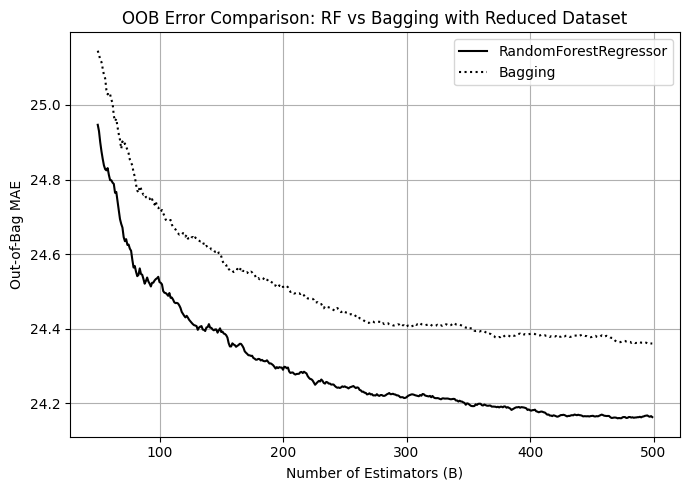

In [ ]:
#OOB errors
plt.figure(figsize=(7, 5))
plt.plot(range(50, 500), oob_rfr_reduced, label='RandomForestRegressor', color='black',)
plt.plot(range(50, 500), oob_bag_reduced, label='Bagging', color='black',linestyle = ':' )
plt.xlabel('Number of Estimators (B)')
plt.ylabel('Out-of-Bag MAE')
plt.title('OOB Error Comparison: RF vs Bagging with Reduced Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


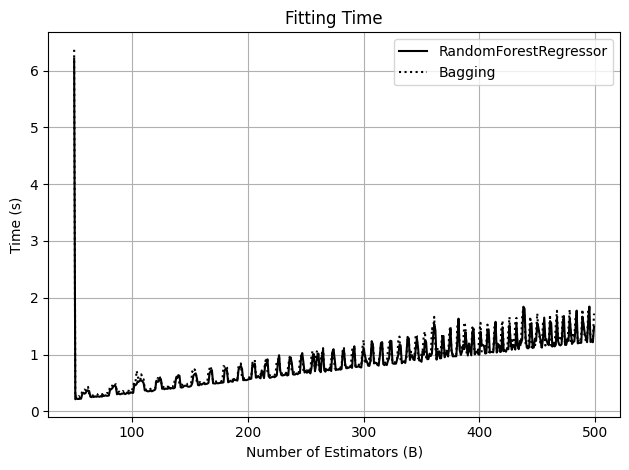

In [ ]:
#fitting time on the right subplot
plt.plot(range(50, 500), computational_cost_rfr, label='RandomForestRegressor', color='black',)
plt.plot(range(50, 500), computational_cost_bag, label='Bagging',color='black',linestyle = ':')
plt.xlabel('Number of Estimators (B)')
plt.ylabel('Time (s)')
plt.title('Fitting Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### RF Optimization

##### Full Dataset

In [ ]:
#parameter grid
m = math.ceil(X_train.shape[1] / 3) # m=p/3

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': [m, 'sqrt'],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#rf regressor
rf = RandomForestRegressor(oob_score=True, random_state=42)


In [ ]:
from sklearn.model_selection import ParameterGrid
#oob  mae score list
oob_mae_rf = []
i = 0
for params in ParameterGrid(param_grid):
    rf.set_params(**params)
    rf.fit(X, y)
    i += 1
    print(f'Step {i}/216')
    oob_predictions = rf.oob_prediction_
    mae = np.mean(np.abs(y - oob_predictions))  # OOB MAE
    oob_mae_rf.append(mae)


results_rf = pd.DataFrame(list(ParameterGrid(param_grid)))
results_rf['oob_mae_score'] = oob_mae_rf

#best model based on MAE
best_model_index_rf = results_rf['oob_mae_score'].idxmin()
best_params_rf = results_rf.iloc[best_model_index_rf]
best_rf_test_mae_full = best_params_rf['oob_mae_score']

print(f"Best parameters: {best_params_rf}")
print(f"Best OOB MAE score: {results_rf.loc[best_model_index_rf, 'oob_mae_score']}")


Step 1/216
Step 2/216
Step 3/216
Step 4/216
Step 5/216
Step 6/216
Step 7/216
Step 8/216
Step 9/216
Step 10/216
Step 11/216
Step 12/216
Step 13/216
Step 14/216
Step 15/216
Step 16/216
Step 17/216
Step 18/216
Step 19/216
Step 20/216
Step 21/216
Step 22/216
Step 23/216
Step 24/216
Step 25/216
Step 26/216
Step 27/216
Step 28/216
Step 29/216
Step 30/216
Step 31/216
Step 32/216
Step 33/216
Step 34/216
Step 35/216
Step 36/216
Step 37/216
Step 38/216
Step 39/216
Step 40/216
Step 41/216
Step 42/216
Step 43/216
Step 44/216
Step 45/216
Step 46/216
Step 47/216
Step 48/216
Step 49/216
Step 50/216
Step 51/216
Step 52/216
Step 53/216
Step 54/216
Step 55/216
Step 56/216
Step 57/216
Step 58/216
Step 59/216
Step 60/216
Step 61/216
Step 62/216
Step 63/216
Step 64/216
Step 65/216
Step 66/216
Step 67/216
Step 68/216
Step 69/216
Step 70/216
Step 71/216
Step 72/216
Step 73/216
Step 74/216
Step 75/216
Step 76/216
Step 77/216
Step 78/216
Step 79/216
Step 80/216
Step 81/216
Step 82/216
Step 83/216
Step 84/216
S

In [ ]:
best_params_rf = {
    'n_estimators': 500,
    'max_features': 13,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'oob_score': True,  # Retain OOB scoring if needed
    'random_state': 42
}
start_time = time.time()
rf_best = RandomForestRegressor(**best_params_rf)
rf_best.fit(X, y)
end_time = time.time()
fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.4f} seconds")
y_pred_best = rf_best.predict(X)
best_rf_train_mae_full = mean_absolute_error(y, y_pred_best)


print(f"MAE train for the best rf full model: {best_rf_train_mae_full}")
print(f"MAE test for the best rf full model: {best_rf_test_mae_full}")
print(f"Fitting time: {fitting_time:.4f} seconds")

Fitting time: 77.2248 seconds
MAE train for the best rf full model: 8.386543645826471
Fitting time: 77.2248 seconds


In [ ]:
#saving scores manually not to run again the CV cells
best_rf_test_mae_full = 22.8055
best_rf_train_mae_full = 8.3865

#### No Outliers

In [ ]:
#oob  mae score list
oob_mae_rf_no = []
i=0
for params in ParameterGrid(param_grid):
    rf.set_params(**params)
    rf.fit(X_no_outliers, y_no_outliers)
    i += 1
    print(f'Step {i}/216')
    # OOB Predictions and MAE
    oob_predictions = rf.oob_prediction_
    mae = np.mean(np.abs(y_no_outliers - oob_predictions))  # Calculate OOB MAE
    oob_mae_rf_no.append(mae)

# Combine results
results_rf_no = pd.DataFrame(list(ParameterGrid(param_grid)))
results_rf_no['oob_mae_score'] = oob_mae_rf_no

# Output best model based on MAE
best_model_index_rf_no = results_rf_no['oob_mae_score'].idxmin()
best_params_rf_no = results_rf_no.iloc[best_model_index_rf_no]
best_rf_test_mae_no = best_params_rf_no['oob_mae_score']


print(f"Best parameters: {best_params_rf_no}")
print(f"Best OOB MAE score: {results_rf_no.loc[best_model_index_rf_no, 'oob_mae_score']}")


Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Step 123
S

In [ ]:
best_params_rf_no_saved = best_params_rf_no
best_params_rf_no_saved

{'n_estimators': 500,
 'max_features': 13,
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'oob_score': True,
 'random_state': 42}

In [ ]:
best_params_rf_no = {
    'n_estimators': 500,
    'max_features': 13,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'oob_score': True,  # Retain OOB scoring if needed
    'random_state': 42
}
start_time = time.time()
rf_best = RandomForestRegressor(**best_params_rf_no)
rf_best.fit(X_no_outliers, y_no_outliers)
end_time = time.time()
fitting_time = end_time - start_time

y_pred_best = rf_best.predict(X_no_outliers)
best_rf_train_mae_no = mean_absolute_error(y_no_outliers, y_pred_best)

print(f"MAE train for the best rf full model: {best_rf_train_mae_no}")
#print(f"MAE test for the best rf full model: {best_rf_test_mae_no}")
print(f"Fitting time: {fitting_time:.4f} seconds")

MAE train for the best rf full model: 8.479008294930875
Fitting time: 49.7984 seconds


In [ ]:
#saving scores manually not to run again the CV cells
best_rf_test_mae_no = 23.0301
best_rf_train_mae_no = 8.4790

## Neural Networks: Recurrent neural networks (RNN)

In [ ]:
#reshaping features
X_train_seq = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_seq = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
# defining the scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# scaling features
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# reshaping scaled data
X_train_seq_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_seq_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# scaling y
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


In [ ]:
# defining function for the RNN model
def create_rnn(units=64, activation='relu', dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2])))
    model.add(Dropout(dropout_rate)) #dropout
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model

# compiling the model
rnn_model = KerasRegressor(model=create_rnn, verbose=0)

#defining early stop
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
# we were planning to use RandomizedSearchCV, but we faced comptability problems for this method
# to solve it, we manually create a random cross-validation to get the best parameters

# define the number of random combination of parameters
n_trials = 30
best_mae = float("inf")
best_params = None
best_model = None

# loop that replaces RandomizedSearchCV
import random
for trial in range(n_trials):
    # we take random parameters from our param grid
    params = {key: random.choice(values) for key, values in param_space.items()}
    print(f"Trial {trial + 1}: Testing params: {params}")

    # create and train the model for the loop
    model = create_rnn(params["units"], params["activation"], params["dropout_rate"], params["optimizer"])

    history = model.fit(
        X_train_seq_scaled, y_train_scaled,
        validation_data=(X_test_seq_scaled, y_test_scaled),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[early_stopping],
        verbose=0
    )

    # evaluation
    test_mae = model.evaluate(X_test_seq_scaled, y_test_scaled, verbose=0)[1]
    print(f"Test MAE: {test_mae}")

    # updating the best model
    if test_mae < best_mae:
        best_mae = test_mae
        best_params = params
        best_model = model

# the best parameters we get
print(f"Best Parameters: {best_params}")

Trial 1: Testing params: {'units': 32, 'activation': 'tanh', 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 100}
Test MAE: 0.12155565619468689
Trial 2: Testing params: {'units': 128, 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 64, 'epochs': 50}
Test MAE: 0.09581267833709717
Trial 3: Testing params: {'units': 32, 'activation': 'tanh', 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 100}
Test MAE: 0.1668723076581955
Trial 4: Testing params: {'units': 128, 'activation': 'tanh', 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 100}
Test MAE: 0.17416177690029144
Trial 5: Testing params: {'units': 128, 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 16, 'epochs': 150}
Test MAE: 0.08570723235607147
Trial 6: Testing params: {'units': 32, 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 100}
Test MAE: 0.106740

In [ ]:
#predictions with the best model

# final evaluation on train and test sets
y_train_pred = best_model.predict(X_train_seq_scaled)
y_test_pred = best_model.predict(X_test_seq_scaled)

# rescaling target
y_train_rescaled = target_scaler.inverse_transform(y_train_scaled)
y_train_pred_rescaled = target_scaler.inverse_transform(y_train_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test_scaled)
y_test_pred_rescaled = target_scaler.inverse_transform(y_test_pred)

# recaling MAE for train and test
mae_train_rnn = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
mae_test_rnn = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)

#train and test MAEs for RNN
print(mae_train_rnn)
print(mae_test_rnn)

333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41.66633147120055
81.93613414299504


# Error analysis

In this section we analyze high-error cases to identify potential reasons (e.g., weather anomalies, public holidays not flagged...etc.)


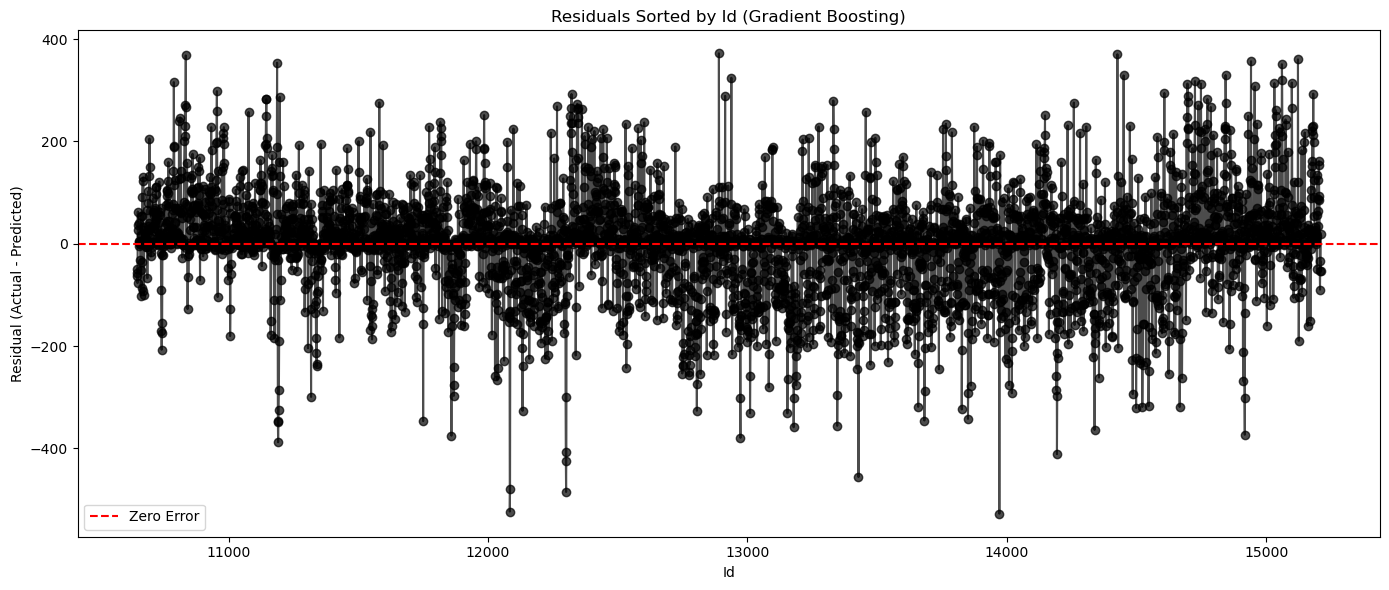

In [ ]:
residuals = y_test - y_pred_test_gb

# Create a DataFrame for analysis
error_analysis_df = pd.DataFrame({
    'Id': X_test.index,  # Assuming X_test has an 'Id' column or an index corresponding to 'Id'
    'Actual': y_test,
    'Predicted': y_pred_test_gb,
    'Residual': residuals
}).sort_values(by='Id')  # Sort by 'Id' to align with your suggestion

# Plot residuals sorted by Id
plt.figure(figsize=(14, 6))
plt.plot(error_analysis_df['Id'], error_analysis_df['Residual'], marker='o', linestyle='-', color='black', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Residuals Sorted by Id (Gradient Boosting)')
plt.xlabel('Id')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
largest_errors = error_analysis_df.nlargest(10, 'Residual', 'all')
smallest_errors = error_analysis_df.nsmallest(10, 'Residual', 'all')
print("Top 10 Overpredicted Values (Largest Positive Residuals):")
print(largest_errors)
print("\nTop 10 Underpredicted Values (Largest Negative Residuals):")
print(smallest_errors)

In [ ]:
test.columns

Index(['Id', 'dteday', 'season', 'yr', 'hr', 'weekday', 'temp', 'atemp', 'hum',
       'windspeed', 'month', 'day', 'spike_flag', 'drop_flag', 'holiday_num',
       'workingday_num', 'weathersit_num', 'temp_hum', 'temp_windspeed',
       'time_of_day_(6.0, 9.0]', 'time_of_day_(9.0, 15.0]',
       'time_of_day_(15.0, 19.0]', 'time_of_day_(19.0, 23.0]', 'hum_windspeed',
       'hr_sin', 'hr_workingday', 'hour_weekday_interaction', 'hr_fourier',
       'day_hr_sin_interaction', 'month_sin', 'month_cos', 'rain',
       'rain_temp_interaction', 'hour_pick', 'hour_lag_1', 'weekday_lag',
       'rolling_temp_mean', 'rolling_humidity_mean', 'rolling_temp_std',
       'rolling_humidity_std'],
      dtype='object')

# MAE Overview

This section provides a comparative analysis of the performance of various machine learning models in predicting bike rentals. We evaluate models using their Mean Absolute Error (MAE) on both the training and test sets, highlighting their ability to fit the training data and generalize to unseen data

                                Train MAE    Test MAE
Linear Reg                      49.388732  103.112682
Ridge                           53.046808  105.732448
Lasso                           53.824801  106.706628
KNN                             40.107700  112.297800
Gradient Boosting               53.943403   66.840200
Gradient Boosting - Restricted  57.504780   54.707000
Decision Tree                   15.380518   78.512626
Bagging                         20.734828   26.150885
Bagging - Reduced               20.734828   27.033077
Random Forest                    8.386544   22.805500
Random Forest - No Ouliers       8.479000   23.030100
RNN                             41.666331   81.936134


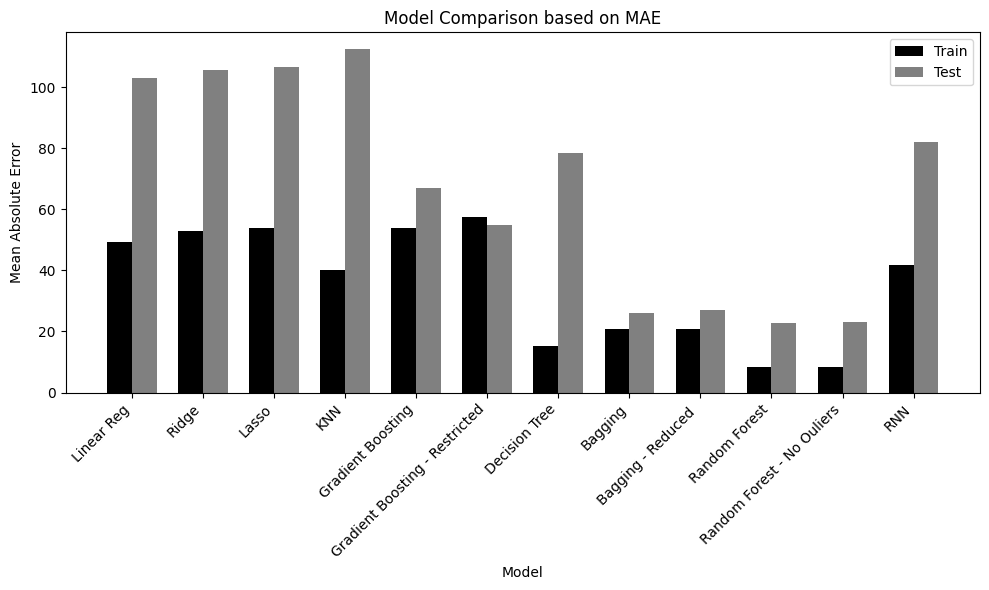

In [ ]:
#MAE results for the base models
results = {
    "Linear Reg": {"Train MAE": mae_train_lin, "Test MAE": mae_test_lin},
   # "Linear Reg: Second order": {"Train MAE": mae_train_poly, "Test MAE": mae_test_poly},
    "Ridge": {"Train MAE": mae_train_ridge, "Test MAE": mae_test_ridge},
    "Lasso": {"Train MAE": mae_train_lasso, "Test MAE": mae_test_lasso},
    "KNN": {"Train MAE": mae_train_pipe_best_k, "Test MAE": mae_test_pipe_best_k},
    "Gradient Boosting": {"Train MAE": train_gb, "Test MAE": test_mae_gb},
    "Gradient Boosting - Restricted": {"Train MAE": train_gb_restricted, "Test MAE": test_mae_gb_restricted},
    "Decision Tree": {"Train MAE": mae_train_best_decision_tree, "Test MAE": mae_test_best_decision_tree},
    "Bagging": {"Train MAE": best_bagging_full_feature_model_train_mae, "Test MAE": best_bagging_full_feature_model_test_mae},
    "Bagging - Reduced ": {"Train MAE": best_bagging_reduced_feature_model_train_mae, "Test MAE": best_bagging_reduced_feature_model_test_mae},
    "Random Forest": {"Train MAE": best_rf_train_mae_full, "Test MAE": best_rf_test_mae_full},
    "Random Forest - No Ouliers": {"Train MAE": best_rf_train_mae_no, "Test MAE": best_rf_test_mae_no},
    "RNN": {"Train MAE": mae_train_rnn, "Test MAE": mae_test_rnn}
}

results_df = pd.DataFrame(results).T
print(results_df)
bar_width = 0.35
x_pos = np.arange(len(results_df.index))  #get x positions

plt.figure(figsize=(10, 6))
#bars for Train MAE
plt.bar(x_pos - bar_width/2, results_df['Train MAE'], width=bar_width, color="black", label="Train")
#bars for Test MAE
plt.bar(x_pos + bar_width/2, results_df['Test MAE'], width=bar_width, color="gray", label="Test")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.title("Model Comparison based on MAE")
plt.xticks(x_pos, results_df.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


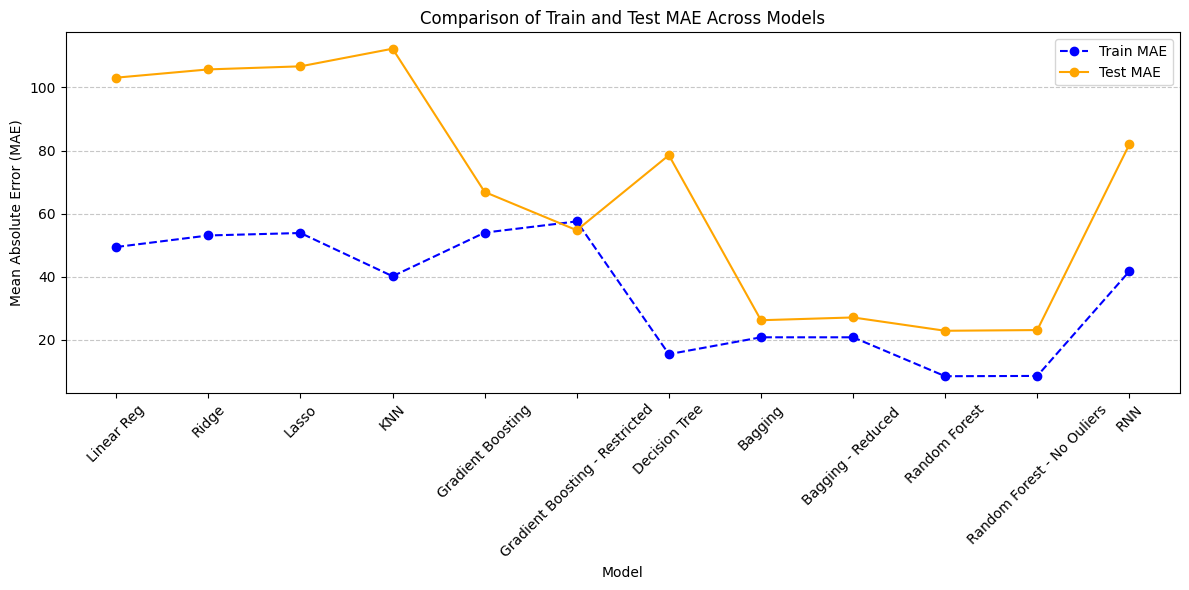

In [ ]:
plt.figure(figsize=(12, 6))

# Line plot for Train MAE
plt.plot(results_df.index, results_df['Train MAE'], marker='o', label='Train MAE', color='blue', linestyle='--')

# Line plot for Test MAE
plt.plot(results_df.index, results_df['Test MAE'], marker='o', label='Test MAE', color='orange', linestyle='-')

# Adding labels, title, and legend
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Model")
plt.title("Comparison of Train and Test MAE Across Models")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization
plt.tight_layout()
plt.show()

# Create csv for submission
When we find the best model we populated the csv for kaggle submission

In [ ]:
# Fill lagged values with the previous or forward value
test = test.fillna(method='ffill').fillna(method='bfill')


<ipython-input-61-5dd9d255acef>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='ffill').fillna(method='bfill')


In [ ]:
best_gbrt.fit(X, y)

y_pred= best_gbrt.predict(test.drop(columns=['Id', 'dteday']))
y_pred = np.rint(y_pred).astype(int) #rounding to integers
# Prepare the submission DataFrame
submission = pd.DataFrame({
    "Id": test['Id'],
    "Y": y_pred
})

# Save submission to a CSV file (if needed)
submission.to_csv("submission.csv", index=False)
submission

Id    Y
0     15212   60
1     15213   11
2     15214    5
3     15215    9
4     15216   10
...     ...  ...
2163  17375  221
2164  17376  166
2165  17377  128
2166  17378   85
2167  17379   51

[2168 rows x 2 columns]